## __JobsPyMatcher: resume optimization for targeted job descriptions__

#### Author: Ernie Sumoso

__Main Sections__

__1.A. Data Collection__

__1.B. Exploratory Data Analysis__

__2. Text wrangling/cleaning__
- Removing stopwords
- number removal
- punctuation removal
- whitespace removal
    
__3. Verbs similarity__
- Sentence & Word tokenization
- identifying POS tags
- Stemming
- Lemmatization
    
__4. Action verbs recommendation__
- Synonyms (WordNet -> Synsets)
- Similarity between words (Synsets)
    
__5. Keywords similarity__
- identifying POS tags
- Named Entity recognition
- Word Collocations: Bigrams (PMI and likelihood ratio)
- Word Collocations: Trigrams (PMI and likelihood ratio)
    
__6. Correcting spelling errors from resume__
- Spell class from autocorrect library
- Suggest function from pattern library
    
__7. Resume sentiment analysis__
- Identifying negative entries using Vader Sentiment
    
__8. Calculating Resume - Job Description simmilarity__

__(matching best resume sentence per job sentence)__
- Bag of Words
- TFIDF
- Cosine similarity

__9. Classification Models__
- Feature extraction using NLTK FreqDist
- Label encoding dataset
- Split dataset train & test
- Classification Models
- Hyperparameter tuning (and metrics)
- Visualizing and comparing best models (confusion matrixes)
- Models evaluation (new data)

### 1. Data Collection

We have 2 main sources of data:
- __resumes dataset__: retrieved from Kaggle source (https://www.kaggle.com/code/medelbachirkhellaf/resume-dataset/input)
- __job descriptions__: web scrapped from Indeed using our GitHub project (https://github.com/NILodio/JobsPyMacher)

The scripts to generate our Job Descriptions datset is located under the directory __/src/data__ in our GitHub project.

We created a class __JobScrapperAPI__ that calls our implemented function __scrape_jobs__ located in __/src/jobscrapper__.

Our project scraps public posts from Indeed Canada (https://ca.indeed.com/), however it can be used for other websites.

After executing the main script __make_raw_data.py__ to generate the dataset, the result is a unified CSV file containing all searched job descriptions.

Some of the parameters implemented for the dataset generation script are:
- __num_jobs__: number of jobs to scrap
- __num_batch__: number of jobs per search term to scrap
- __JOBS_WEBSITE__: set as environment variable, webiste to scrap
- __JOBS_COUNTRY__: set as environment variable, country to search for jobs (default Canada)
- __SEARCH_TERMS__: set as environment variable, list of search terms to insert in the website for job scrapping

Our generated dataset was saved into __jobs_13547.csv__. The most relevant columns are:
- __description__: job description from the post
- __search term__: search term utilized on the website

Let's load both data sources (resumes and job descriptions) into memory.

In [1]:
import pandas as pd
# loading the job descriptions dataset
df_jobs = pd.read_csv('jobs_13547.csv')
df_jobs.tail()

site                                            job_url  \
13541  indeed  https://ca.indeed.com/viewjob?jk=6cdc51ad05295587   
13542  indeed  https://ca.indeed.com/viewjob?jk=cdfdabac384c17eb   
13543  indeed  https://ca.indeed.com/viewjob?jk=9ac1c7981bb3c9bb   
13544  indeed  https://ca.indeed.com/viewjob?jk=4aa684848233fe0b   
13545  indeed  https://ca.indeed.com/viewjob?jk=f8ce8d3bb493631d   

                                          job_url_direct  \
13541  https://www.westlaketalent.com/planning-and-in...   
13542  http://ca.indeed.com/job/sql-developer-and-bus...   
13543  https://jsv3.recruitics.com/redirect?rx_cid=36...   
13544  https://cclfg.cclgroup.com/careers/opportuniti...   
13545  https://jobs.toronto.ca/jobsatcity/job/Toronto...   

                                                   title  \
13541                       Planning & Inventory Analyst   
13542  SQL Developer and Business Intelligence Specia...   
13543                                   Business Analyst   
13544            Data Analyst, Investment Data Analytics   
13545                                   BUSINESS ANALYST   

                                    company               location  \
13541                      Westlake Careers     Woodbridge, ON, CA   
13542                          Dex Clothing  Saint-Laurent, QC, CA   
13543                     GFL Environmental    Mississauga, ON, CA   
13544  Connor, Clark & Lunn Financial Group      Vancouver, BC, CA   
13545                       City of Toronto        Toronto, ON, CA   

                  job_type date_posted  interval  min_amount  ...  \
13541             fulltime  2024-03-08       NaN         NaN  ...   
13542             fulltime  2024-03-05       NaN         NaN  ...   
13543             fulltime  2024-02-22       NaN         NaN  ...   
13544                  NaN  2024-02-05       NaN         NaN  ...   
13545  temporary, fulltime  2023-10-13       NaN         NaN  ...   

                                       company_addresses  \
13541                                                NaN   
13542        390 Deslauriers, Saint-Laurent, QC, H4N-1V8   
13543                                        Vaughan, ON   
13544                                                NaN   
13545  100 Queen Street West, Toronto, ON, Canada, On...   

                    company_industry  company_num_employees  \
13541                            NaN                    NaN   
13542                         Retail              51 to 200   
13543                            NaN                10,000+   
13544   Banks And Financial Services           501 to 1,000   
13545                     Government                10,000+   

            company_revenue  \
13541                   NaN   
13542   $25M to $100M (USD)   
13543      $1B to $5B (USD)   
13544                   NaN   
13545  more than $10B (USD)   

                                     company_description  \
13541                                                NaN   
13542                                                NaN   
13543  GFL is committed to providing a greener altern...   
13544                                                NaN   
13545                                                NaN   

                                          logo_photo_url  \
13541                                                NaN   
13542  https://d2q79iu7y748jz.cloudfront.net/s/_squar...   
13543  https://d2q79iu7y748jz.cloudfront.net/s/_squar...   
13544  https://d2q79iu7y748jz.cloudfront.net/s/_squar...   
13545  https://d2q79iu7y748jz.cloudfront.net/s/_squar...   

                                        banner_photo_url        ceo_name  \
13541                                                NaN             NaN   
13542                                                NaN             NaN   
13543  https://d2q79iu7y748jz.cloudfront.net/s/_heade...  Patrick Dovigi   
13544                                                NaN             NaN   
13545        

Our Kaggle source contains the resumes in PDF format and organized under multiple folders (inside __data__),

so we need to properly __extract the text from the PDFs.__

Let's also add the name of the folders (professions) as one column.

In [2]:
from os import listdir # list files of a directory
from os.path import isfile, isdir, join # file operations
import PyPDF2 # pdf processing library

# class in charge of loading our resume data source
class ResumeDataLoader:
    def get_list_of_files(self, data_path):
        '''
            function: get_list_of_files -> creates a list of the file paths 
            arg: data_path (str) -> path of the file
            return: files (list) -> List of files
        '''
        # get list of files from the data path
        files = [file for file in listdir(data_path) if isfile(join(data_path, file))]
        # get list of folders from the data path
        dirs = [(file, join(data_path, file)) for file in listdir(data_path) if isdir(join(data_path, file))]
        # get files from each folder
        for i, dir_ in enumerate([d[1] for d in dirs]):
            files += [(dirs[i][0], join(dir_, file), file) for file in listdir(dir_) if isfile(join(dir_, file))]
        return files # return all files
    
    def get_text_from_pdf(self, file_path):
        '''
            function: get_text_from_pdf -> fetch the data from the file path
            arg: file_path (str) -> path of the file
            return: text (str) -> content of the file
        '''
        file = open(file_path, 'rb') # open file in read mode
        reader = PyPDF2.PdfReader(file) # instantiate the pdf2 class to read our file
        text = "" 
        for page in reader.pages: # extracting text of each page
            text += page.extract_text()
        file.close()
        return text # return the entire pdf raw text

    def convert_pdfs_into_dataframe(self, pdfs):
        '''
            function: convert_pdfs_into_dataframe -> converts pdf data into a data frame 
            arg: pdfs (list) -> list of the file paths
            return: df (pandas.core.frame.DataFrame) -> Data frame 
        '''
        rows = [] # save future dataframe rows into a list
        for pdf in pdfs: # for each file, create a dictionary (keys-columns, values-row values)
            rows.append({'file': pdf[2], 'profession': pdf[0], 'resume':self.get_text_from_pdf(pdf[1])})
        return pd.DataFrame(rows) # return the resultant dataframe

In [3]:
rdl = ResumeDataLoader() # instantiate our class
files = rdl.get_list_of_files('data') # read all file names (recursively under data folder)
print("# Files:", len(files)) # display resultant list
files[:5]

# Files: 2484


[('ACCOUNTANT', 'data\\ACCOUNTANT\\10554236.pdf', '10554236.pdf'),
 ('ACCOUNTANT', 'data\\ACCOUNTANT\\10674770.pdf', '10674770.pdf'),
 ('ACCOUNTANT', 'data\\ACCOUNTANT\\11163645.pdf', '11163645.pdf'),
 ('ACCOUNTANT', 'data\\ACCOUNTANT\\11759079.pdf', '11759079.pdf'),
 ('ACCOUNTANT', 'data\\ACCOUNTANT\\12065211.pdf', '12065211.pdf')]

In [4]:
df_resumes = rdl.convert_pdfs_into_dataframe(files) # convert pdfs into text into a dataframe
df_resumes.tail()

file profession  \
2479  86322251.pdf    TEACHER   
2480  86597425.pdf    TEACHER   
2481  90363254.pdf    TEACHER   
2482  96547039.pdf    TEACHER   
2483  99244405.pdf    TEACHER   

                                                 resume  
2479  READING TEACHER\nSummary\nI am a highly motiva...  
2480  HISTORY TEACHER\nProfessional Summary\nTo be e...  
2481  TEACHER\nSummary\nHighly ethical, dependable, ...  
2482  TEACHER\nSummary\nTalented early education pro...  
2483  Kpandipou Koffi\nSummary\nCompassionate teachi...

Dealing with missing values:

Let's __remove missing values from job description texts and resumes__, and remain with a fully textual columns.

These missing values won't contribute anything to our analysis.

In [5]:
# identifying number of missing values from jobs
df_jobs[df_jobs['description'].isna()]

Empty DataFrame
Columns: [site, job_url, job_url_direct, title, company, location, job_type, date_posted, interval, min_amount, max_amount, currency, is_remote, emails, description, company_url, company_url_direct, company_addresses, company_industry, company_num_employees, company_revenue, company_description, logo_photo_url, banner_photo_url, ceo_name, ceo_photo_url, search_term]
Index: []

[0 rows x 27 columns]

In [6]:
# identifying number of missing values from resumes
df_resumes[df_resumes['resume'].isna()]

Empty DataFrame
Columns: [file, profession, resume]
Index: []

In [7]:
# dropping missing values and checking missing values again
df_resumes = df_resumes[df_resumes['resume'].notna()]
df_resumes[df_resumes['resume'].isna()]

Empty DataFrame
Columns: [file, profession, resume]
Index: []

Our 'search_term' column (from job descriptions) and 'profession' column (from resumes) should contain same values.

Let's normalize the columns so we can map the resumes to the job descriptions in later steps.

In [8]:
# show search term value counts from job descriptions
df_jobs['search_term'].unique()

array(['accountant', 'advocate', 'agriculture', 'apparel', 'arts',
       'automobile', 'aviation', 'banking', 'bpo', 'business development',
       'chef', 'construction', 'consultant', 'designer', 'digital media',
       'engineering', 'finance', 'fitness', 'healthcare', 'hr',
       'information technology', 'public relations', 'sales', 'teacher',
       'software engineer', 'software developer', 'data scientist',
       'data analyst'], dtype=object)

In [9]:
# show resume professions value counts
df_resumes['profession'].unique()

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

In [10]:
# lower case and replace lines for whitepsaces
df_resumes['profession'] = df_resumes['profession'].apply(lambda x : x.lower().replace('-',' '))
df_resumes['profession'].unique()

array(['accountant', 'advocate', 'agriculture', 'apparel', 'arts',
       'automobile', 'aviation', 'banking', 'bpo', 'business development',
       'chef', 'construction', 'consultant', 'designer', 'digital media',
       'engineering', 'finance', 'fitness', 'healthcare', 'hr',
       'information technology', 'public relations', 'sales', 'teacher'],
      dtype=object)

In [11]:
# save resume dataset as a CSV for fast reference in later steps
df_resumes.to_csv('resumes.csv')

### 1. (B) Exploratory Data Analysis

Now that we have our data available, let's __perform an exploratory analysis on both resumes and job descriptions.__

For this we will define a __class__ in charge of the EDA.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class in charge of the EDA of a given dataframe
class EDA():
    # constructor of the class
    def __init__(self, df):
        '''
            function: Constructor
            arg: df (pandas.core.frame.DataFrame) -> dataframe to perform EDA
            return: None
        '''
        self.df = df
        self.basicEDA()
        
    # method to perform the entire EDA pipeline using our methods
    def basicEDA(self):
        '''
            function: basicEDA -> This function will call the function that are used for EDA
            arg: None
            return: None
        '''
        # perform the entire EDA using our methods
        self.shapeAndSizeFunction()
        self.nullValuesFunction()
        self.duplicatedFunction()
        self.infoFunction()
    
    # method to display the Shape of the dataframe
    def shapeAndSizeFunction(self):
        '''
            function: shapeAndSizeFunction -> It is a function to check the shape and the size of the data set
            arg: None
            return: None
        '''
        # checking the shape of the data frame
        self.printLine()
        shape = self.df.shape
        print("SHAPE OF DATAFRAME:")
        print('Columns = {}'.format(shape[0]))
        print('Rows = {}'.format(shape[1]))
        size = self.df.size
        self.printLine()
        print("SIZE OF DATAFRAME: {}".format(size))
        
    # method to display the nullvalues of the dataframe
    def nullValuesFunction(self):
        '''
            function: nullValuesFunction -> It is a function to check the count of the missing values in the dataframe
            arg: None
            return: None
        '''
        # cheking the missing values
        nullValues = self.df.isna().sum()
        noNull = 'No Null values' if nullValues.sum == 0 else nullValues
        self.printLine()
        print('Checking the missing values:\n')
        print('Missing values:\n{}'.format(noNull))
    
    # method to display the duplicated rows of the dataframe
    def duplicatedFunction(self):
        '''
            function: duplicatedFunction -> It is a function to check the count of the duplicate rows in the dataframe
            arg: None
            return: None
        '''
        # checking the duplicates
        duplicates = self.df.duplicated().sum()
        noduplicates = 'No Duplicat values' if duplicates == 0 else duplicates
        self.printLine()
        print('Checking the Duplicate values:')
        print('Duplicate values = {}'.format(noduplicates))
        
    # method to display the DataFrame info method that contains datatypes for each column
    def infoFunction(self):
        '''
            function: infoFunction -> This function will give the basic information about the dataframe
            arg: None
            return: None
        '''
        # information of the data set
        self.printLine()
        print('The information: ')
        print(self.df.info(),'')
    
    # method to plot a pie chart based of a certain column
    def boolPlot(self, col):
        '''
            function: boolPlot -> This function plots pie chart for boolean values
            arg: col(str) -> name of the column
            return: None
        '''
        size = self.df[col].value_counts()
        plt.pie(size, labels=size.index, autopct='%1.1f%%')
        plt.legend(labels=size.index)
        plt.title('boolean feature:{}'.format(col))
        plt.show()
        
    # method to plot a bar chart (horizontal or vertical) based of a certain column
    def barPlot(self, col, orient='h'):
        '''
            function: barPlot -> This function plots bar chart for catagorical values.
            arg: col(str) -> name of the column
            return: None
        '''
        size = self.df[col].value_counts()
        percent = round((size * 100) / self.df.shape[0], 1) # claulating the percentage of the frequency
        if orient == 'h':
            x = percent.values
            y = percent.index
        else:
            x = percent.index
            y = percent.values
        sns.barplot(x=x, y=y, palette='dark', orient=orient)
        plt.xticks(rotation=90)
        plt.title('feature:{}'.format(col))
        
        plt.show()
    
    # method to print a simple line
    def printLine(self):
        '''
            function: printLine -> This function will print a line
            arg: None
            return: None
        '''
        print('-'*50, '\n')
        

#### EDA of Job Descriptions dataset

In [13]:
# creating a class instance of the EDA for job descriptions dataset
print('EDA FOR JOB DESCRIPTIONS')
eda = EDA(df_jobs)

EDA FOR JOB DESCRIPTIONS
-------------------------------------------------- 

SHAPE OF DATAFRAME:
Columns = 13546
Rows = 27
-------------------------------------------------- 

SIZE OF DATAFRAME: 365742
-------------------------------------------------- 

Checking the missing values:

Missing values:
site                         0
job_url                      0
job_url_direct               0
title                        0
company                    109
location                     0
job_type                  2506
date_posted                  0
interval                 13546
min_amount               13546
max_amount               13546
currency                 13546
is_remote                    0
emails                   11202
description                  0
company_url                 96
company_url_direct        4710
company_addresses         5494
company_industry         10214
company_num_employees     5501
company_revenue           7213
company_description       7948
logo_photo_url  

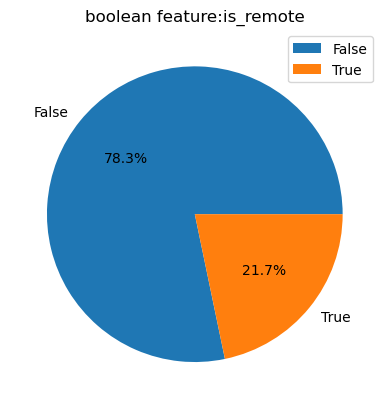

In [14]:
# plot pie chart of remote column
eda.boolPlot('is_remote')

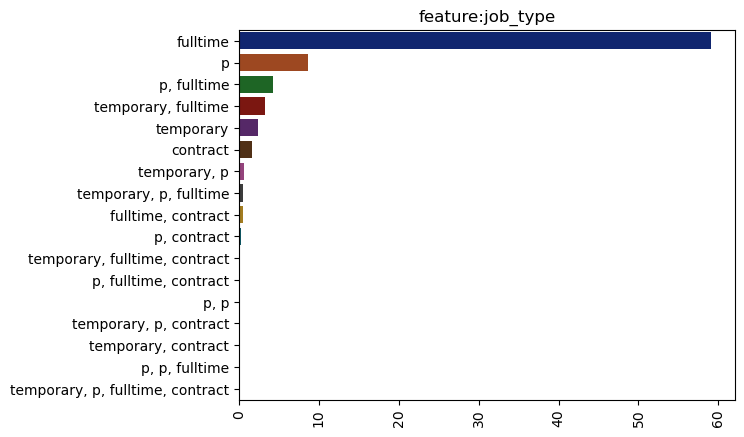

In [15]:
# plot horizontal bar chart of job types
eda.barPlot('job_type', orient='h')

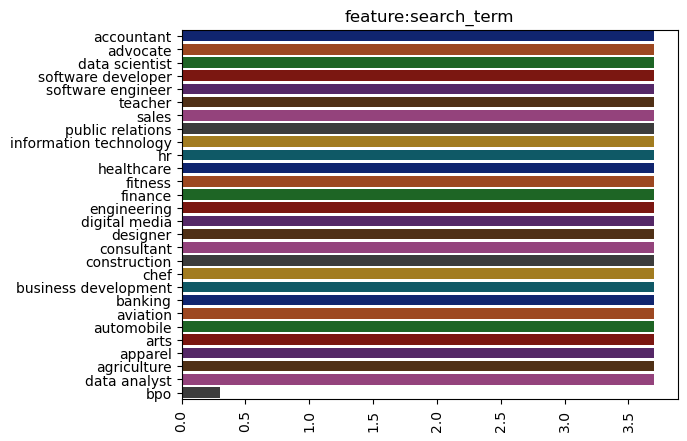

In [16]:
# plot horizontal bar chart of search terms used for scrapping the jobs (basically industries)
eda.barPlot('search_term', orient='h')

#### EDA of Resumes dataset

In [17]:
# creating a class instance of the EDA for the resumes dataset
print('EDA FOR RESUMES')
edaResume = EDA(df_resumes)

EDA FOR RESUMES
-------------------------------------------------- 

SHAPE OF DATAFRAME:
Columns = 2484
Rows = 3
-------------------------------------------------- 

SIZE OF DATAFRAME: 7452
-------------------------------------------------- 

Checking the missing values:

Missing values:
file          0
profession    0
resume        0
dtype: int64
-------------------------------------------------- 

Checking the Duplicate values:
Duplicate values = No Duplicat values
-------------------------------------------------- 

The information: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        2484 non-null   object
 1   profession  2484 non-null   object
 2   resume      2484 non-null   object
dtypes: object(3)
memory usage: 77.6+ KB
None 


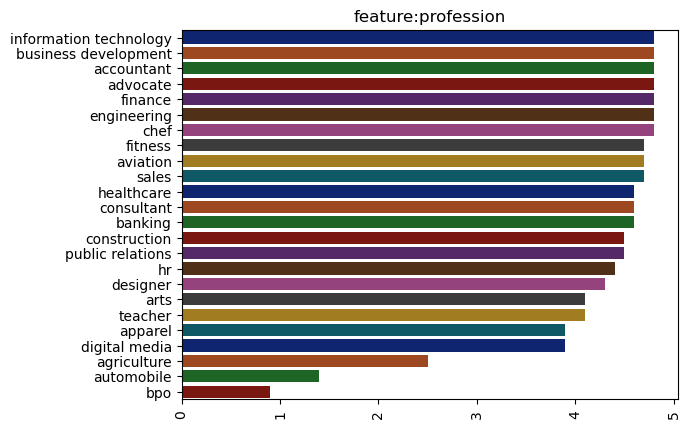

In [18]:
# plot horizontal bar chart of resume professions (basically industries)
edaResume.barPlot('profession', orient='h')

### 2. Text wrangling/cleaning
Let's create a class in charge of the following actions to clean our data sources:
- __Removing stopwords__ -> by using NLTK methods
- __Number removal__ -> by using Regex methods
- __Punctuation removal__ -> using String methods
- __Whitespace removal__ -> by using Regex methods

In [19]:
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
import string

# class in charge of performing cleaning operations into raw text
class TextCleaning:
    def __init__(self):
        '''
            function: Constructor
            return: class instance
        '''
        self.STOPWORDS = stopwords.words('english') # set stopwords constant
        
    def remove_stopwords(self, text):
        '''
            function: remove_stopwords
            arg: text (str) -> text to perform the stopwords removal
            return: text (str) -> text without stopwords
        '''
        # tokenize the text
        tokenized_text = word_tokenize(text)
        
        # loop through text words and remove stopwords
        i = 0
        while i < len(tokenized_text):
            # if word is a stopword remove from tokenized list
            if tokenized_text[i].lower() in self.STOPWORDS:
                tokenized_text.pop(i)
                i -= 1
                continue
            i += 1
        return ' '.join(tokenized_text) # return string with remaining words joined by whitespace
    
    def remove_numbers(self, text, replace=''):
        '''
            function: remove_numbers
            arg: text (str) -> text to perform the numbers removal
                 replace (str) -> optional text to replace numbers with
            return: text (str) -> text without numbers
        '''
        # removing numbers from text using regex sub method
        return re.sub(r'\d+', replace, text)
    
    def remove_punctuation(self, text, replace=' '):
        '''
            function: remove_punctuation
            arg: text (str) -> text to perform the punctuation removal
                 replace (str) -> optional text to replace punctuations with
            return: text (str) -> text without punctuation
        '''
        # removing punctuation from text using string methods
        return text.translate(str.maketrans(replace, replace, string.punctuation))
    
    def remove_whitespaces(self, text, replace=' '):
        '''
            function: remove_whitespaces
            arg: text (str) -> text to perform the whitespaces removal
                 replace (str) -> optional text to replace whitespaces with
            return: text (str) -> text without whitespaces
        '''
        # removing whitespaces from text using regex sub method
        return re.sub(r'\s+', ' ', text.strip())
        
tc = TextCleaning()
tc

In [20]:
# let's test some methods on our job descriptions
df_jobs['description'].apply(tc.remove_punctuation)

0        About us\n\nAt MRR we are proud that our essen...
1        Job Req ID 561\nDepartment Cash Management and...
2        Work Location\nToronto Ontario Canada\nHours\n...
3        Reporting to the Chief Financial Officer and o...
4        Who we are\n\n  \n\n\nImagine being part of a ...
                               ...                        
13541    CONTRACT  temporary position for less than a y...
13542    We are seeking a skilled SQL Developer and BI ...
13543    As a Business Analyst you will work at the int...
13544    Data Analyst Investment Data Analytics\nConnor...
13545    Job ID 30364\nJob Category Policy Planning  Re...
Name: description, Length: 13546, dtype: object

In [21]:
# let's test some methods on our job descriptions
df_jobs['description'].apply(tc.remove_whitespaces)

0        **About us** At MRR, we are proud that our ess...
1        **Job Req ID:** 561 **Department:** Cash Manag...
2        Work Location: Toronto, Ontario, Canada Hours:...
3        Reporting to the Chief Financial Officer and o...
4        **Who we are** Imagine being part of a team wh...
                               ...                        
13541    **CONTRACT -** temporary position for less tha...
13542    We are seeking a skilled SQL Developer and BI ...
13543    As a Business Analyst, you will work at the in...
13544    **Data Analyst, Investment Data Analytics** **...
13545    **Job ID:** 30364 **Job Category:** Policy, Pl...
Name: description, Length: 13546, dtype: object

In [22]:
# Let's clean our resumes and job descriptions
def clean_text_column(df_original, col, stops=True, numbers=True, punctuations=True, whitespaces=True, lowercase=True):
    
    tc = TextCleaning() # instantiate text cleaning class
    df = df_original[col].copy() # copy of the column for safety
    
    # perform actions depending on each flags
    if lowercase:
        df = df.apply(str.lower)
    if stops: 
        df = df.apply(tc.remove_stopwords)
    if numbers:
        df = df.apply(tc.remove_numbers)
    if punctuations:
        df = df.apply(tc.remove_punctuation)
    if whitespaces:
        df = df.apply(tc.remove_whitespaces)
        
    return df # return copy of the column after operations

In [23]:
# clean the job descriptions texts
df_jobs['description_clean'] = clean_text_column(df_jobs, 'description')
df_jobs[['description_clean', 'search_term']]

description_clean   search_term
0      us mrr proud essential services technologies d...    accountant
1      job req id department cash management investme...    accountant
2      work location toronto ontario canada hours lin...    accountant
3      reporting chief financial officer principals c...    accountant
4      imagine part team human connection underlies e...    accountant
...                                                  ...           ...
13541  contract temporary position less year summary ...  data analyst
13542  seeking skilled sql developer bi business inte...  data analyst
13543  business analyst work intersection finance ope...  data analyst
13544  data analyst investment data analytics connor ...  data analyst
13545  job id job category policy planning research d...  data analyst

[13546 rows x 2 columns]

In [24]:
# clean the resumes texts
df_resumes['resume_clean'] = clean_text_column(df_resumes, 'resume')
df_resumes[['resume_clean', 'profession']]

resume_clean  profession
0     accountant summary financial accountant specia...  accountant
1     staff accountant summary highly analytical det...  accountant
2     accountant professional summary obtain positio...  accountant
3     senior accountant experience company name june...  accountant
4     senior accountant professional summary senior ...  accountant
...                                                 ...         ...
2479  reading teacher summary highly motivated educa...     teacher
2480  history teacher professional summary employed ...     teacher
2481  teacher summary highly ethical dependable dili...     teacher
2482  teacher summary talented early education profe...     teacher
2483  kpandipou koffi summary compassionate teaching...     teacher

[2484 rows x 2 columns]

### 3. Verbs simmilarity

Now that the texts are clean, let's proceed with the first feature of our tool and find the verbs simmilarity between the resumes and job descriptions.

We will test and compare both approaches for the verbs:
- __Stemming__
- __Lemmatization__

In [25]:
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

class VerbsAnalyzer():
    def get_unique_words(self, text, print_=True):
        '''
            function: get_unique_words -> function to identify unique words from a text
            arg: text (str) -> raw text
                 print_ (bool) -> print (or not) additional information of the process
            return: unique_words (list) -> list of unique words from the text
        '''
        tokens = word_tokenize(text)
        unique_words = list(set(tokens))
        if print_:
            print("# Total words:", len(tokens))
            print("# Unique words:", len(unique_words))
        return unique_words
    
    def get_verbs(self, words, pos_prefix='V'):
        '''
            function: get_verbs -> this function identify verbs from the list of words by using part of speech tags
            arg: words (list) -> list of words
                 pos_prefix (str) -> prefix of the required pos tags, 'V' by default to identify verbs only
            return: tags (list) -> (word, pos tag) if the POS tag starts with the parameter pos_prefix
        '''
        text = ' '.join(words) # joining tokens into one text
        blob = TextBlob(text) # pos tagging words from text
        # identifying and returning only verbs from POS tags
        return [tag for tag in blob.tags if tag[1].startswith(pos_prefix)]
    
    def stem_verbs(self, words):
        '''
            function: stem_verbs -> apply stemming to a list of words
            arg: words (list) -> list of words
            return: (list) -> words after stemming
        '''
        stemmer = PorterStemmer() # instantiate stemmer
        return [stemmer.stem(word) for word in words] # apply stemming on all words
    
    def lemmatize_verbs(self, words, pos="v"):
        '''
            function: lemmatize_verbs -> apply lemmatization to a list of words
            arg: words (list) -> list of words
            return: (list) -> words after lemmatization
        '''
        lem = WordNetLemmatizer() # instantiate lemmatizer
        return [lem.lemmatize(word, pos=pos) for word in words] # apply lemmatization on all words

In [26]:
# function to extract verbs from text, apply a method and return list of only verbs with the method applied
def get_processed_verbs_from_text(text, method='stem', print_=True):
    
    va = VerbsAnalyzer() # instantiate our class
    unique_words = va.get_unique_words(text, print_=print_) # get resume unique words
    pos_verbs = va.get_verbs(unique_words) # extract only verbs from both
    
    if print_: # print insights if required
        print("# Original verbs:", len(pos_verbs))
        print("  Original Verbs (trimmed):")
        display(pos_verbs[:5])
        
    verbs = [verb[0] for verb in pos_verbs] # get only verbs without POS tags
    
    # apply technique over verbs and return processed list
    if method == 'stem':
        processed_verbs = va.stem_verbs(verbs)
    elif method == 'lemmatize':
        processed_verbs = va.lemmatize_verbs(verbs)
        
    if print_: # print insights if required
        print("# Unique verbs:", len(list(set(processed_verbs))))
        print("  Processed Verbs (trimmed):")
        display(processed_verbs[:5])
    
    return list(set(processed_verbs)) # return only unique verbs

In [27]:
# Let's test our function using one random resume and STEMMING
test_resume = df_resumes['resume_clean'][0]
_ = get_processed_verbs_from_text(test_resume, method='stem', print_=True)

# Total words: 2198
# Unique words: 891
# Original verbs: 226
  Original Verbs (trimmed):


[('july', 'VBP'),
 ('discussed', 'VBN'),
 ('completed', 'VBD'),
 ('targeted', 'VBN'),
 ('noted', 'VBD')]

# Unique verbs: 187
  Processed Verbs (trimmed):


['juli', 'discuss', 'complet', 'target', 'note']

In [28]:
# Let's test our function using one random job and STEMMING
test_job = df_jobs['description_clean'][0]
_ = get_processed_verbs_from_text(test_job, method='stem', print_=True)

# Total words: 371
# Unique words: 273
# Original verbs: 56
  Original Verbs (trimmed):


[('disposal', 'VBP'),
 ('drive', 'VB'),
 ('develop', 'VB'),
 ('recognizes', 'VBZ'),
 ('planning', 'VBG')]

# Unique verbs: 53
  Processed Verbs (trimmed):


['dispos', 'drive', 'develop', 'recogn', 'plan']

In [29]:
# Let's test our function using one random resume and LEMMATIZATION
test_resume = df_resumes['resume_clean'][0]
_ = get_processed_verbs_from_text(test_resume, method='lemmatize', print_=True)

# Total words: 2198
# Unique words: 891
# Original verbs: 226
  Original Verbs (trimmed):


[('july', 'VBP'),
 ('discussed', 'VBN'),
 ('completed', 'VBD'),
 ('targeted', 'VBN'),
 ('noted', 'VBD')]

# Unique verbs: 188
  Processed Verbs (trimmed):


['july', 'discuss', 'complete', 'target', 'note']

In [30]:
# Let's test our function using one random job and LEMMATIZATION
test_job = df_jobs['description_clean'][0]
_ = get_processed_verbs_from_text(test_job, method='lemmatize', print_=True)

# Total words: 371
# Unique words: 273
# Original verbs: 56
  Original Verbs (trimmed):


[('disposal', 'VBP'),
 ('drive', 'VB'),
 ('develop', 'VB'),
 ('recognizes', 'VBZ'),
 ('planning', 'VBG')]

# Unique verbs: 52
  Processed Verbs (trimmed):


['disposal', 'drive', 'develop', 'recognize', 'plan']

Now we can __compare the verbs from both texts__ and create a __metric for simmilarity.__

Overall we identify the following:

- __Simmilarity__: number of common verbs / number of verbs in job description
- __Common verbs__: between resume and job description
- __Lacking verbs__: verbs present in the job description that are NOT present in the resume

In [31]:
# function to calculate verbs simmilarity between 2 texts, common & lacking verbs
def get_verbs_simmilarity(text_resume, text_job, method='stem', print_=True):
    # extract and process verbs from both texts
    verbs_resume = get_processed_verbs_from_text(text_resume, method=method, print_=False)
    verbs_job = get_processed_verbs_from_text(text_job, method=method, print_=False)
    
    # get common verbs between both texts
    verbs_common = [verb for verb in verbs_resume if verb in verbs_job]
    
    # get lacking verbs (present in job description, but not in resume)
    verbs_lacking = [verb for verb in verbs_job if verb not in verbs_resume]
    
    # calculate, print, and return simmilarity
    simmilarity = len(verbs_common) * 100 / len(verbs_job)
    if print_: 
        print("% Verbs Simmilarity: {:.2f}".format(simmilarity))
        print("Common Verbs (trimmed):")
        display(verbs_common[:5])
        print("Lacking Verbs (trimmed):")
        display(verbs_lacking[:5])
    return simmilarity, verbs_common, verbs_lacking

Let's test our function using __Stemming and Lemmatization__

In [32]:
test_resume = df_resumes['resume_clean'][0]
test_job = df_jobs['description_clean'][0]
sim, common, lacking = get_verbs_simmilarity(test_resume, test_job, method='stem')

% Verbs Simmilarity: 32.08
Common Verbs (trimmed):


['use', 'identifi', 'develop', 'expect', 'report']

Lacking Verbs (trimmed):


['seek', 'drive', 'believ', 'packag', 'conduct']

In [33]:
test_resume = df_resumes['resume_clean'][0]
test_job = df_jobs['description_clean'][0]
sim, common, lacking = get_verbs_simmilarity(test_resume, test_job, method='lemmatize')

% Verbs Simmilarity: 34.62
Common Verbs (trimmed):


['use', 'experience', 'develop', 'make', 'expect']

Lacking Verbs (trimmed):


['seek', 'disposal', 'drive', 'package', 'recycle']

Now, to __compare both methods__ let's choose 1 job description and calculate simmilarities using

all resumes targeted for that job description industry. First let's visualize the available industries.

In [34]:
# display the available industries that we have from resumes
df_resumes['profession'].value_counts()

information technology    120
business development      120
accountant                118
advocate                  118
finance                   118
engineering               118
chef                      118
fitness                   117
aviation                  117
sales                     116
healthcare                115
consultant                115
banking                   115
construction              112
public relations          111
hr                        110
designer                  107
arts                      103
teacher                   102
apparel                    97
digital media              96
agriculture                63
automobile                 36
bpo                        22
Name: profession, dtype: int64

In [35]:
# Function to calculate the simmilarity between a job description text and a list of resumes
def get_verb_simmilarity_lists(job_text, resumes):
    # calculate simmilarities (with both methods) between the resumes and same job description
    sims_stem = []
    sims_lemmatize= []
    for resume_text in resumes:
        # calculate verb simmilarities and save values
        sim_stem, _, _ = get_verbs_simmilarity(resume_text, job_text, method='stem', print_=False)
        sim_lemm, _, _ = get_verbs_simmilarity(resume_text, job_text, method='lemmatize', print_=False)
        sims_stem.append(sim_stem)
        sims_lemmatize.append(sim_lemm)
    return sims_stem, sims_lemmatize

In [36]:
import matplotlib.pyplot as plt

# Function to plot the simmilarity lines and difference from the lists returned by previous function
def plot_verb_simmilarity_comparison(sims_stem, sims_lemmatize, title=''):
    # calculate the difference between metrics (lemmatization - stemming)
    sims_difference = [sim[1]-sim[0] for sim in zip(sims_stem, sims_lemmatize)]
    
    # plot lines simmilarities (from stem and lemmatize) and difference between both (gray)
    plt.plot(sims_stem, color='red', label='Stemming')
    plt.plot(sims_lemmatize, '-.', color='blue', label='Lemmatizing')
    plt.plot(sims_difference, color='gray', label='Difference: Lem - Stem')
    plt.axhline(y=0, color='black', linestyle='-.') # plot horizontal line at y=0 for reference
    plt.title(title + "Verb simmilarity: Stemming vs Lemmatizing verbs")
    plt.xlabel("Resume ID")
    plt.ylabel("Verb Simmilarity %")
    plt.legend()
    plt.show()

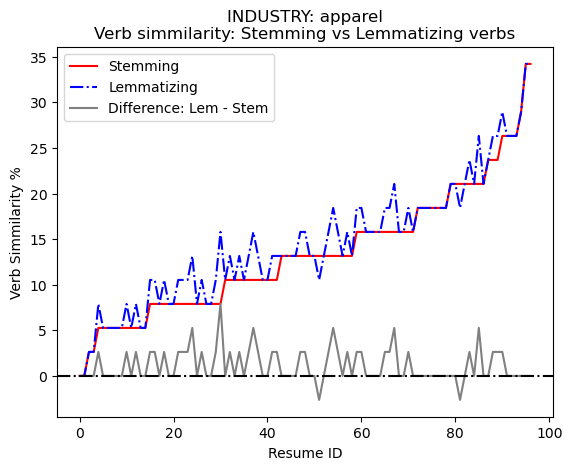

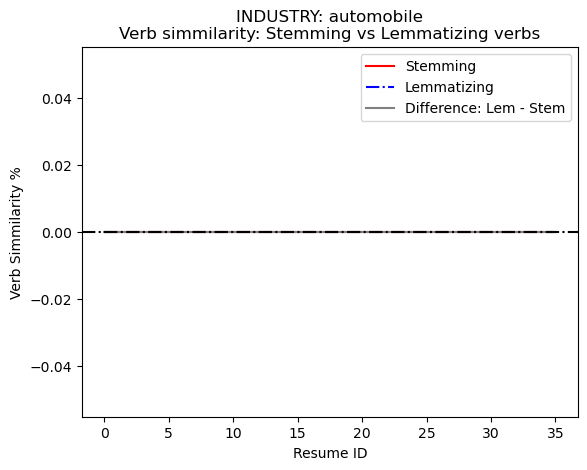

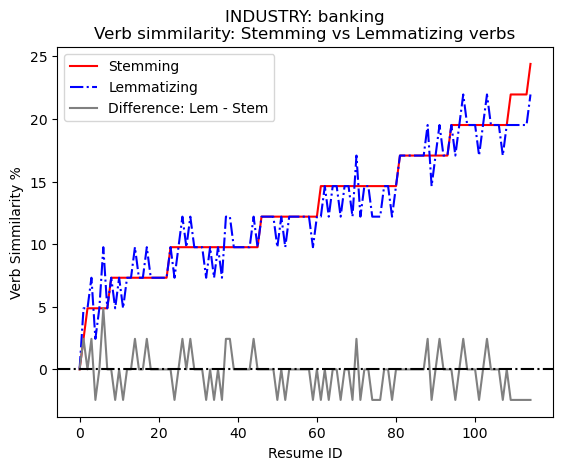

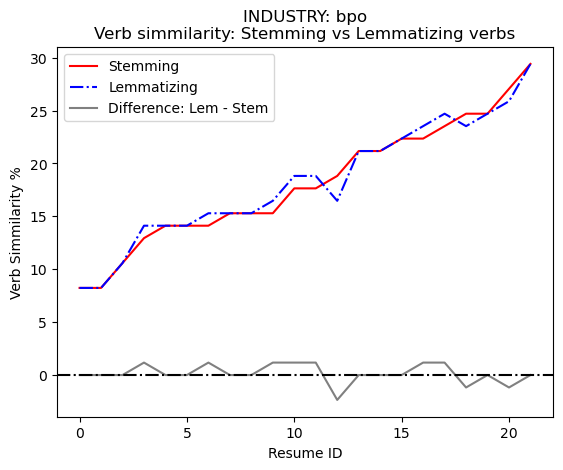

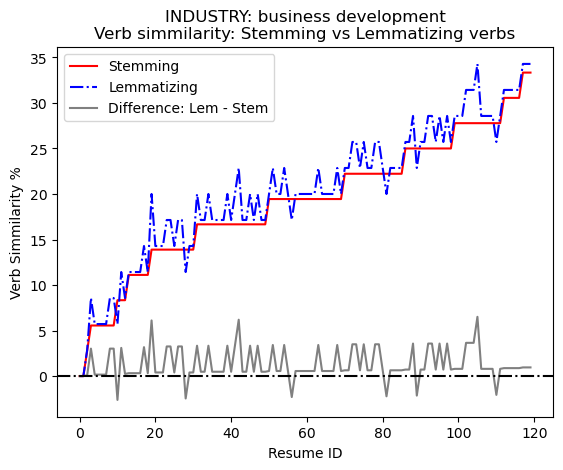

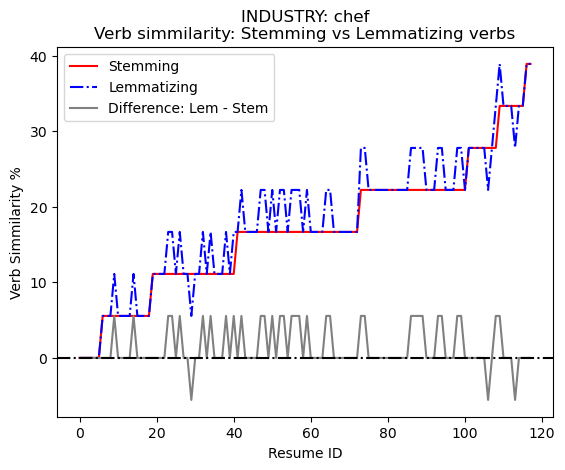

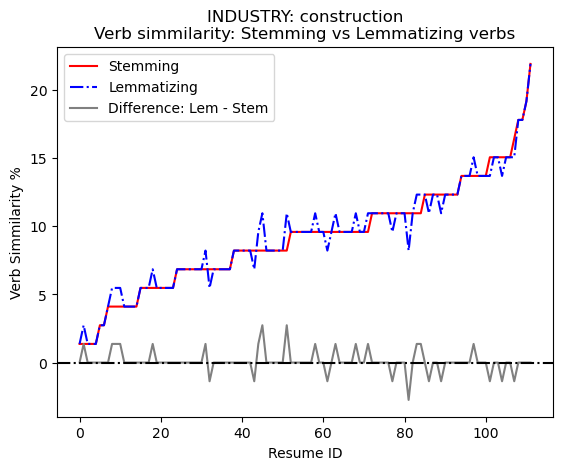

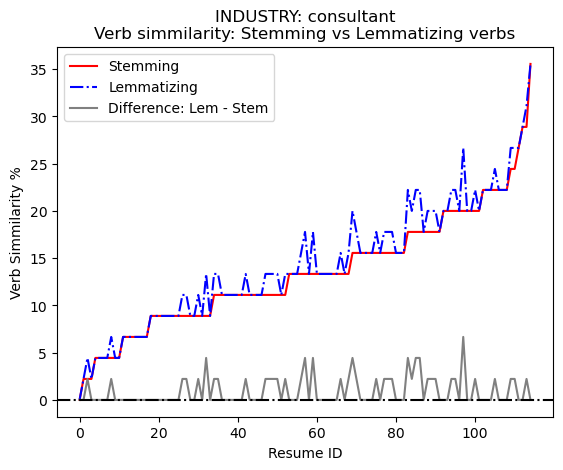

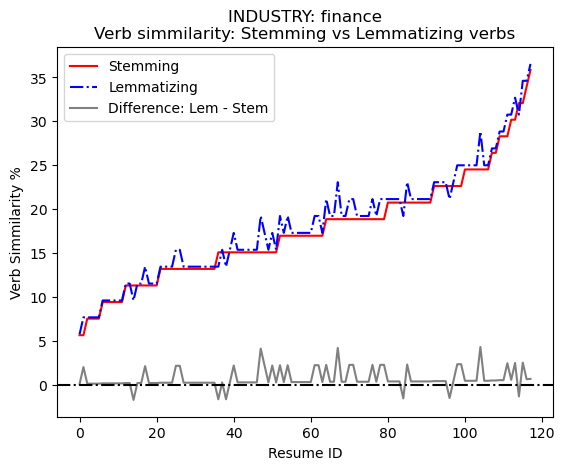

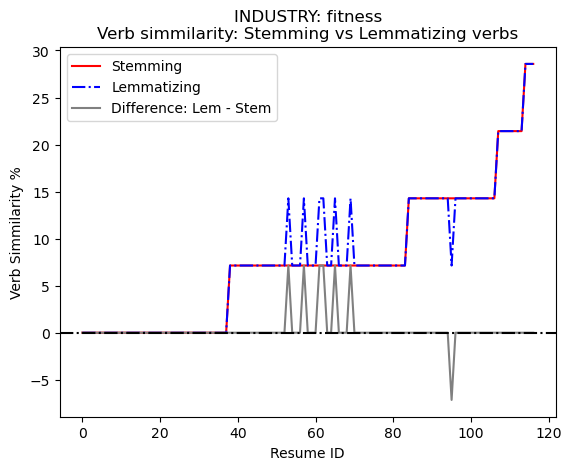

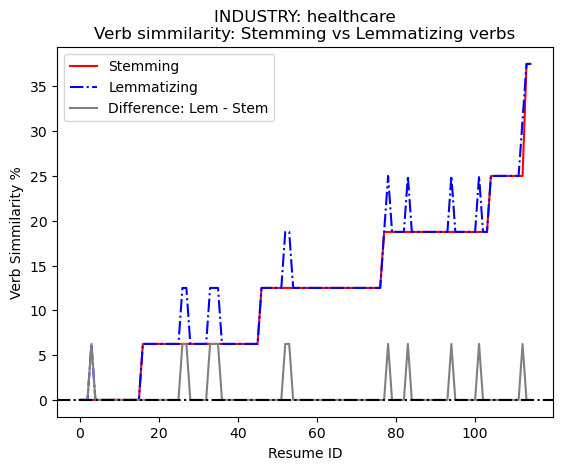

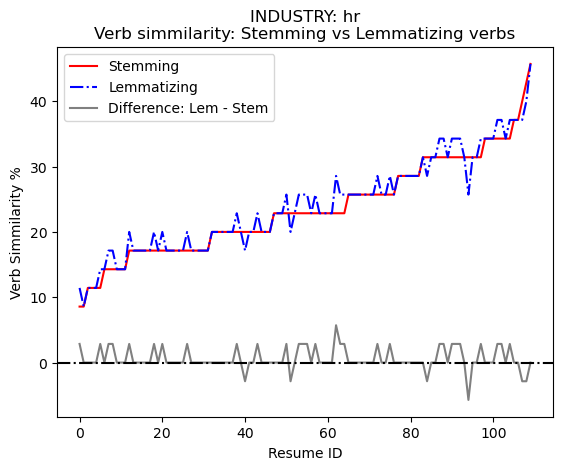

In [37]:
# Function to calculate and compare all simmilarities between 1 random industry job description and all available resumes for that industry
def compare_verb_simmilarities(df_resumes, df_jobs):
    # loop through industries
    for industry in df_resumes['profession'].unique():
        # small text change for the job description dataset
        industry_job = industry.lower().replace('-', ' ')
        # take 1 random industry job description from dataset
        job_text = df_jobs[df_jobs['search_term'] == industry_job]['description_clean'].reset_index(drop=True)[0]
        # get all resumes from that industry
        resumes = df_resumes[df_resumes['profession'] == industry]['resume_clean'].reset_index(drop=True)
        
        # get simmilarities, sort them (for best visualization) and plot the visualizations
        sims_stem, sims_lemmatize = get_verb_simmilarity_lists(job_text, resumes)
        sorted_sims = sorted(list(zip(sims_stem, sims_lemmatize)), key=lambda x: x[0])
        sorted_stem = [sim[0] for sim in sorted_sims]
        sorted_lemm = [sim[1] for sim in sorted_sims]
        plot_verb_simmilarity_comparison(sorted_stem, sorted_lemm, title='INDUSTRY: ' + industry + '\n')
            

compare_verb_simmilarities(df_resumes, df_jobs)

__From the resultant plots, we notice:__
- Overall the verb simmilarities don't change significantly with either of the 2 methods.
- The difference between verb-simmilarity using both methods (lemmatizing minus stemming) are mostly positive. This suggests that Lemmatizing verbs increases the verb simmilarity (to the job description) in most resumes.
- Few cases present negative difference, meaning that stemming has increased verb-simmilarity of those particular resume.

Based on results we decided that our project will use verb lemmatization to compare verb simmilarity (between resume-job description).

### 4. Action verbs recommendation

In the previous step we identified:
- common verbs between the resumes and job descriptions.
- lacking verbs: verbs that are present in the job description but NOT in the resume

Using this information we can __suggest__ our users possible __verbs to add__ to their resumes by using:
- identifying POS
- Synonyms (WordNet -> Synsets)

We can also __rank our synonym suggestions by using__:
- Simmilarity between words (Synsets)

In [38]:
# Let's define some random resume and job description (from same industry) to test our functions
test_resume = df_resumes['resume_clean'][0]
test_job = df_jobs['description_clean'][0]
sim, verbs_common, verbs_lack = get_verbs_simmilarity(test_resume, test_job, method='lemmatize')

% Verbs Simmilarity: 34.62
Common Verbs (trimmed):


['use', 'experience', 'develop', 'make', 'expect']

Lacking Verbs (trimmed):


['seek', 'disposal', 'drive', 'package', 'recycle']

In [59]:
import nltk
from nltk.corpus import wordnet

# function to get synonyms from a given word
def get_synonyms(word):
    synonyms = []
    
    # loop through the synsets of the word
    for syn in wordnet.synsets(word):
        
        # loop through the lemmas for each synset
        for lemma in syn.lemmas():
            
            # save the synonym, replacing underscores for whitespaces
            synonyms.append(lemma.name().replace('_',' '))
            
    return list(set(synonyms)) # return unique synonyms only

# function to get the synset from a word
def get_synset(word):
    # convert word into a set of chars
    word_set = set(list(word))

    # loop through synsets of the word
    for synset in wordnet.synsets(word):
        
        # extract the set of characters from the synset
        synset_set = set(list(synset.name().split('.')[0]))
        
        # if set of synset chars is contained in the word set of chars then return the synset
        if synset_set <= word_set:
            return synset
    return None

# pick one random verb from the resume lacking verbs and get their synonyms
test_verb = verbs_lack[0]
synonyms = get_synonyms(test_verb)
print("Verb:", test_verb)
print("Synonyms:")
synonyms[:10]

Verb: seek
Synonyms:


['seek', 'search', 'look for', 'attempt', 'try', 'assay', 'essay']

Our implemented functions allow us __to get the synonyms of a verb.__

Now let's try __ranking these synonyms by their word similarity__ with the original verb.

In [60]:
# function to find the synonyms of a word and return them ranked by simmilarity with the original word
def get_synonyms_ranked(word, print_=False):
    
    synset_word = get_synset(word) # get the synset of the word
    synonyms = get_synonyms(word) # get the synonyms of the word
    
    # loop through the synonyms
    synonyms_ranked = []
    for synonym in synonyms:
        
        # get the synset of the synonym
        synset_synonym = get_synset(synonym)
        
        # calculate the simmilarity between original word and synonym
        if synset_synonym is None:
            simmilarity = 0.0
        else:
            simmilarity = synset_word.wup_similarity(synset_synonym)
        
        # print some insights if required
        if print_:
            print("Synonym:", synonym)
            print("- Synonym Synset:", synset_synonym)
            print("- Simmilarity:", round(simmilarity, 2))
        
        # append the synonym with its simmilarity as a tuple
        if word != synonym:
            synonyms_ranked.append((synonym, simmilarity))
    
    # return synonyms sorted by simmilarity with original word
    return sorted(synonyms_ranked, key=lambda x:x[1], reverse=True)

# get the synonyms from the lacking verb, and rank them by word simmilarity with original verb from job description
get_synonyms_ranked(test_verb, print_=True)

Synonym: seek
- Synonym Synset: Synset('seek.n.01')
- Simmilarity: 1.0
Synonym: search
- Synonym Synset: Synset('search.n.01')
- Simmilarity: 0.57
Synonym: look for
- Synonym Synset: None
- Simmilarity: 0.0
Synonym: attempt
- Synonym Synset: Synset('attempt.n.01')
- Simmilarity: 0.57
Synonym: try
- Synonym Synset: Synset('try.v.01')
- Simmilarity: 0.18
Synonym: assay
- Synonym Synset: Synset('assay.n.01')
- Simmilarity: 0.38
Synonym: essay
- Synonym Synset: Synset('essay.n.01')
- Simmilarity: 0.31


[('search', 0.5714285714285714),
 ('attempt', 0.5714285714285714),
 ('assay', 0.375),
 ('essay', 0.3076923076923077),
 ('try', 0.18181818181818182),
 ('look for', 0.0)]

Our final function returns a list of tuples (synonym, simmilarity) __sorted by the simmilarities.__

With this function we can successfully recommend the user other possible verbs to add on their resumes.

### 5. Keywords simmilarity

We will proceed with one of the most important features of the project, keyword extraction from the job descriptions.

To achieve this we will use the following techniques:
- __POS tagging__
- __Named Entity recognition__
- __Word Collocations: Bigrams__ (based on PMI)
- __Word Collocations: Trigrams__ (based on PMI)

However, to detect keywords we need the upper cases untouched. We will create another column of our texts (job desc. and resumes) but without changing upper cases.

In [41]:
# get another version of the job descriptions without changing upper cases
df_jobs['description_upper'] = clean_text_column(df_jobs, 'description', lowercase=False)
df_jobs[['description_upper', 'search_term']]

description_upper   search_term
0      us MRR proud essential services technologies d...    accountant
1      Job Req ID Department Cash Management Investme...    accountant
2      Work Location Toronto Ontario Canada Hours Lin...    accountant
3      Reporting Chief Financial Officer Principals C...    accountant
4      Imagine part team human connection underlies e...    accountant
...                                                  ...           ...
13541  CONTRACT temporary position less year SUMMARY ...  data analyst
13542  seeking skilled SQL Developer BI Business Inte...  data analyst
13543  Business Analyst work intersection Finance Ope...  data analyst
13544  Data Analyst Investment Data Analytics Connor ...  data analyst
13545  Job ID Job Category Policy Planning Research D...  data analyst

[13546 rows x 2 columns]

In [42]:
# get another version of the resumes without changing upper cases
df_resumes['resume_upper'] = clean_text_column(df_resumes, 'resume', lowercase=False)
df_resumes[['resume_upper', 'profession']]

resume_upper  profession
0     ACCOUNTANT Summary Financial Accountant specia...  accountant
1     STAFF ACCOUNTANT Summary Highly analytical det...  accountant
2     ACCOUNTANT Professional Summary obtain positio...  accountant
3     SENIOR ACCOUNTANT Experience Company Name June...  accountant
4     SENIOR ACCOUNTANT Professional Summary Senior ...  accountant
...                                                 ...         ...
2479  READING TEACHER Summary highly motivated educa...     teacher
2480  HISTORY TEACHER Professional Summary employed ...     teacher
2481  TEACHER Summary Highly ethical dependable dili...     teacher
2482  TEACHER Summary Talented early education profe...     teacher
2483  Kpandipou Koffi Summary Compassionate teaching...     teacher

[2484 rows x 2 columns]

__Identifying keywords by named entity recognition.__

In [43]:
from nltk import sent_tokenize

# function to extract the keywords form a text, returns a list of Trees from NLTK
def get_named_entities(text):
    sentences = sent_tokenize(text) # sentence tokenization
    tokens = [word_tokenize(sent) for sent in sentences] # word tokenize each sentence
    tags = [nltk.pos_tag(sent) for sent in tokens] # pos tagging each word
    chunks = nltk.ne_chunk_sents(tags, binary=True) # set named entity chunks
    named_entities = []
    for sent in chunks: # save named entities from text if they are labeled NE
        for chunk in sent:
            if hasattr(chunk, "label") and chunk.label() == 'NE':
                named_entities.append(chunk)
    return named_entities

In [44]:
# select a random job description to test our functions
test_job = df_jobs['description_upper'][12000]
test_job[:100] # show first 100 characters

'Union USW Local Job Opportunity Information Technology Services Posting Date April Closing Date Apri'

In [45]:
# test our named entity extraction function
named_entities = get_named_entities(test_job)
named_entities

[Tree('NE', [('Union', 'NNP')]),
 Tree('NE', [('Schedule', 'NNP'), ('Fulltime', 'NNP'), ('Victoria', 'NNP'), ('University', 'NNP')]),
 Tree('NE', [('University', 'NNP')]),
 Tree('NE', [('SLGBTQI', 'NNP')]),
 Tree('NE', [('Human', 'NNP'), ('Resources', 'NNPS'), ('Department', 'NNP')]),
 Tree('NE', [('Interim', 'NNP')]),
 Tree('NE', [('SQL', 'NNP'), ('Server', 'NNP')]),
 Tree('NE', [('Victoria', 'NNP'), ('University', 'NNP')]),
 Tree('NE', [('Computer', 'NNP'), ('Science', 'NNP'), ('Software', 'NNP')]),
 Tree('NE', [('HTML', 'NNP')]),
 Tree('NE', [('AODA', 'NNP'), ('Experience', 'NNP')]),
 Tree('NE', [('SQL', 'NNP'), ('Server', 'NNP')]),
 Tree('NE', [('SQL', 'NNP')]),
 Tree('NE', [('Events', 'NNP'), ('Management', 'NNP'), ('Catering', 'NNP')]),
 Tree('NE', [('Demonstrated', 'NNP')]),
 Tree('NE', [('DUTIES', 'NNP'), ('Application', 'NNP')]),
 Tree('NE', [('RESTful', 'NNP')]),
 Tree('NE', [('Ability', 'NNP')]),
 Tree('NE', [('Participate', 'NNP')]),
 Tree('NE', [('Keep', 'NNP')]),
 Tree('N

In [46]:
# function to further process our named entities
def process_named_entities(nes, tags=['NNP', 'NNPS']):
    # loop through the named entities passed as parameters
    named_entities = []
    for ne in nes:
        
        # filter only those named entitites that are tagged same as the parameter 'tags'
        named_entity = [word[0] for word in ne if word[1] in tags]
        
        # from the remaining parts of the named entity, joined them as a single string (e.g. 'Barack Obama')
        named_entity = ' '.join(named_entity)
        
        # if the resultant named entity is an empty string discard them, otherwise save it
        if named_entity == "": continue
        named_entities.append(named_entity)
    
    # return unique named entities sorted in alphabetical order
    return sorted(list(set(named_entities)))

process_named_entities(named_entities, 'NNP')

['AODA Experience',
 'APPLY Internal',
 'Ability',
 'Apply Victoria University',
 'Computer Science Software',
 'DUTIES Application',
 'Dayforce Please',
 'Demonstrated',
 'Events Management Catering',
 'HTML',
 'Human Department',
 'Interim',
 'Internal Opportunities',
 'Keep',
 'Participate',
 'RESTful',
 'SLGBTQI',
 'SQL',
 'SQL Server',
 'Schedule Fulltime Victoria University',
 'Union',
 'University',
 'Victoria University']

__Identifying keywords with Bigram and Trigram word collocations__,

__using both metrics PMI and Likelihood Ratio.__

In [47]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures

# class in charge of retrieving bigrams and trigrams from a text based on likelihood ratio metric
class NGramsFinder:
    def get_top_n_bigrams(self, text, n, metric='pmi'):
        '''
            function: get_top_n_bigrams -> finds the top n number of bigrams 
            arg: text (str) -> text to find the bigrams 
                 n (int) -> number of bigrams to find
            return: (list) -> list of tuples containg bigrams
        '''
        tokens = word_tokenize(text) # tokenize text
        bcf = BigramCollocationFinder.from_words(tokens) # instantiate bigram finder
        
        # return best n number of bigrams based on metric
        if metric == 'pmi':
            return bcf.nbest(BigramAssocMeasures.pmi, n)
        elif metric == 'likelihood':
            return bcf.nbest(BigramAssocMeasures.likelihood_ratio, n)
    
    def get_top_n_trigrams(self, text, n, metric='pmi'):
        '''
            function: get_top_n_trigrams -> finds the top n number of trigrams 
            arg: text (str) -> text to find the trigrams 
                 n (int) -> number of bigrams to find
            return: (list) -> list of tuples containg trigrams
        '''
        tokens = word_tokenize(text) # tokenize text
        tcf = TrigramCollocationFinder.from_words(tokens) # instantiate trigram finder
        
        # return best n number of trigrams based on metric
        if metric == 'pmi':
            return tcf.nbest(TrigramAssocMeasures.pmi, n)
        elif metric == 'likelihood':
            return tcf.nbest(TrigramAssocMeasures.likelihood_ratio, n)

In [48]:
# test our bigram finder
ngf = NGramsFinder()
print("Bigrams (top 5) using LIKELIHOOD RATIO:")
display(ngf.get_top_n_bigrams(test_job, 5, metric='likelihood'))
print("Brigrams (top 5) using PMI:")
display(ngf.get_top_n_bigrams(test_job, 5, metric='pmi'))

Bigrams (top 5) using LIKELIHOOD RATIO:


[('Victoria', 'University'),
 ('Information', 'Technology'),
 ('Technology', 'Services'),
 ('Date', 'April'),
 ('Management', 'Catering')]

Brigrams (top 5) using PMI:


[('APIs', 'seamless'),
 ('AgileScrum', 'methodologies'),
 ('Appointment', 'Type'),
 ('Bachelor', '’'),
 ('Collaborate', 'crossfunctional')]

In [49]:
# test our trigrams finder
ngf = NGramsFinder()
print("Trigrams (top 5) using LIKELIHOOD RATIO:")
display(ngf.get_top_n_trigrams(test_job, 5, metric='likelihood'))
print("Trigrams (top 5) using PMI:")
display(ngf.get_top_n_trigrams(test_job, 5, metric='pmi'))

Trigrams (top 5) using LIKELIHOOD RATIO:


[('Information', 'Technology', 'Services'),
 ('Apply', 'Victoria', 'University'),
 ('Fulltime', 'Victoria', 'University'),
 ('SUMMARY', 'Victoria', 'University'),
 ('Victoria', 'University', 'REQUIRED')]

Trigrams (top 5) using PMI:


[('APIs', 'seamless', 'integration'),
 ('Appointment', 'Type', 'Contract'),
 ('Bachelor', '’', 'degree'),
 ('Computer', 'Science', 'Software'),
 ('Customer', 'service', 'focused')]

With this particular job description we get better results using PMI. 

However, we have to test with multiple job descriptions.

To __compare the keyword simmilarity__ between resume and job description

we will __define a function to compare any simmilarity (named entity, bigram, or trigram)__.

So that we can compare results and make conclusions.

In [50]:
# function to calculate keyword simmilarity between 2 texts
def get_simmilarity(text_resume, text_job, method='named_entity', ngram_metric='pmi', ngram_terms=15, print_=True):
    # extract keywords (named entities, bigram, or trigram) from text
    if method == 'named_entity':
        keywords_resume = process_named_entities(get_named_entities(text_resume))
        keywords_job = process_named_entities(get_named_entities(text_job))
    elif method == 'bigram':
        ngf = NGramsFinder()
        keywords_resume = ngf.get_top_n_bigrams(text_resume, ngram_terms, metric = ngram_metric)
        keywords_job = ngf.get_top_n_bigrams(text_job, ngram_terms, metric = ngram_metric)
    elif method == 'trigram':
        ngf = NGramsFinder()
        keywords_resume = ngf.get_top_n_trigrams(text_resume, ngram_terms, metric = ngram_metric)
        keywords_job = ngf.get_top_n_trigrams(text_job, ngram_terms, metric = ngram_metric)
    
    # get common keywords between both texts
    keywords_common = [keyword for keyword in keywords_resume if keyword in keywords_job]
    
    # get lacking keywords (present in job description, but not in resume)
    keyword_lacking = [keyword for keyword in keywords_job if keyword not in keywords_resume]
    
    # calculate, print, and return simmilarity; avoid the division by 0 in case there's no keywords in the job description
    simmilarity = 0 if len(keywords_job) == 0 else len(keywords_common) * 100 / len(keywords_job)
    
    # print insights if required
    if print_: 
        print("% Keywords Simmilarity: {:.2f}".format(simmilarity))
        print("Common Keywords (trimmed):")
        display(keywords_common[:5])
        print("Lacking Keywords (trimmed):")
        display(keyword_lacking[:5])
    return simmilarity, keywords_common, keyword_lacking

In [51]:
# select a random resume & job description from same industry to test our functions
test_job = df_jobs['description_upper'][9570]
test_resume = df_resumes['resume_upper'][2070]
print("Job Description (trimmed):\n- ", test_job[:100])
print("Resume (trimmed):\n- ", test_resume[:100])

Job Description (trimmed):
-  Role name Azure Solution Architect Toronto Hybrid Long Term Contract Key Skills Required Data Framew
Resume (trimmed):
-  INFORMATION TECHNOLOGY SPECIALIST INFORMATION SECURITY OFFICER Profile blah blah Core Qualifications


In [52]:
# test our named entity simmilarity
_ = get_simmilarity(test_resume, test_job, method='named_entity')

% Keywords Simmilarity: 7.69
Common Keywords (trimmed):


['SQL']

Lacking Keywords (trimmed):


['ADF',
 'Azure Solution Architect Toronto Hybrid Long Term Contract Key Skills Required Data Frameworks',
 'Databricks Delta Live',
 'Hadoop Spark Kafka',
 'Informatica Experience']

In [53]:
# test our bigram simmilarity
_ = get_simmilarity(test_resume, test_job, method='bigram', ngram_metric='pmi')

% Keywords Simmilarity: 0.00
Common Keywords (trimmed):


[]

Lacking Keywords (trimmed):


[('ADF', 'ADLS'),
 ('ADLS', 'Gen'),
 ('ANA', 'Apptozacom'),
 ('Apptozacom', 'Email'),
 ('Architect', 'Toronto')]

In [54]:
# test our trigram simmilarity
_ = get_simmilarity(test_resume, test_job, method='trigram', ngram_metric='pmi')

% Keywords Simmilarity: 0.00
Common Keywords (trimmed):


[]

Lacking Keywords (trimmed):


[('ADF', 'ADLS', 'Gen'),
 ('ANA', 'Apptozacom', 'Email'),
 ('Apptozacom', 'Email', 'ana'),
 ('Architect', 'Toronto', 'Hybrid'),
 ('Contract', 'Key', 'Skills')]

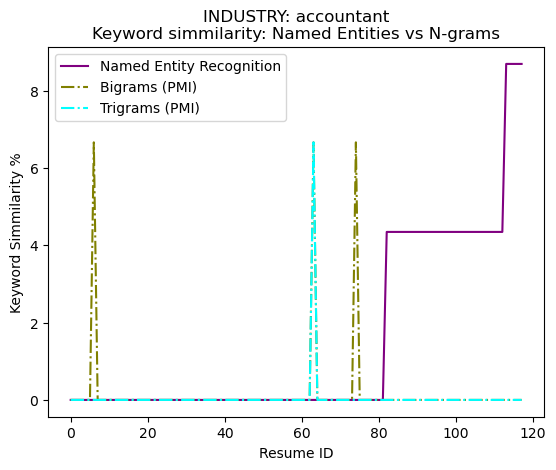

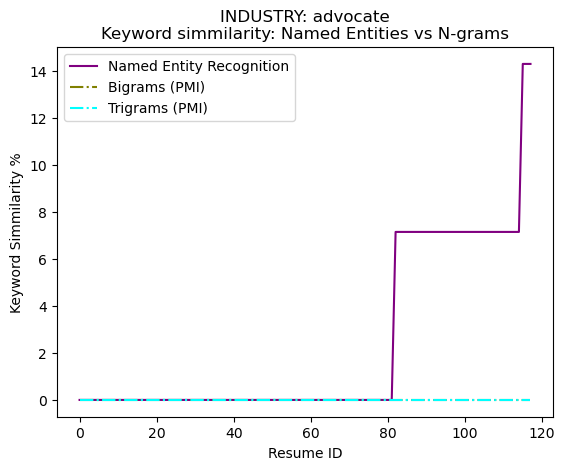

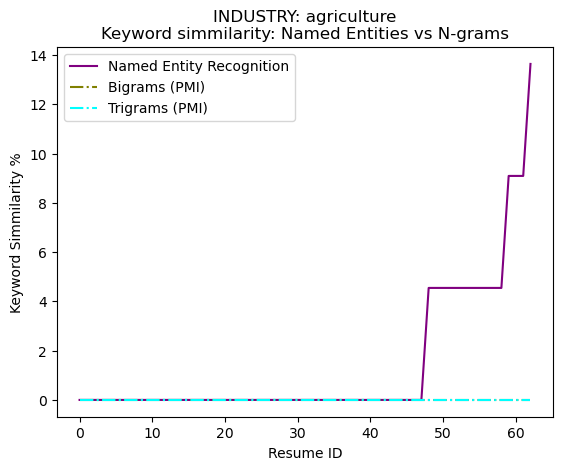

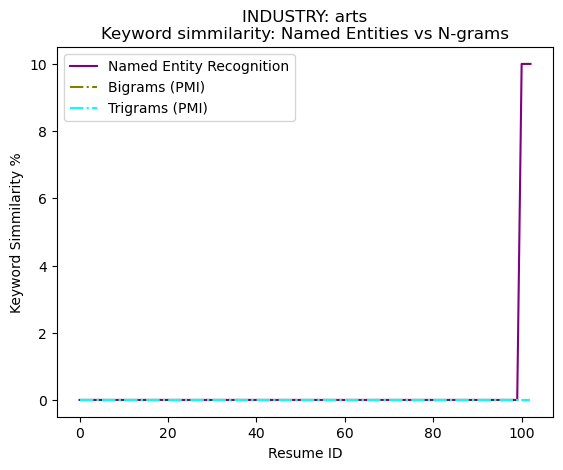

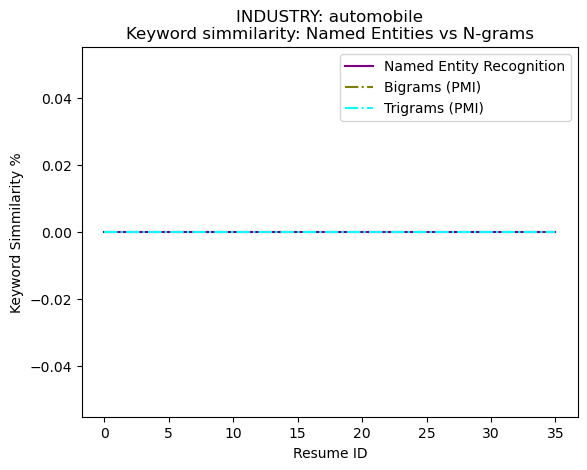

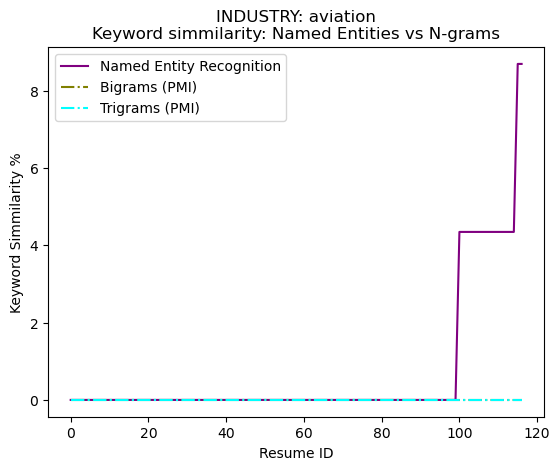

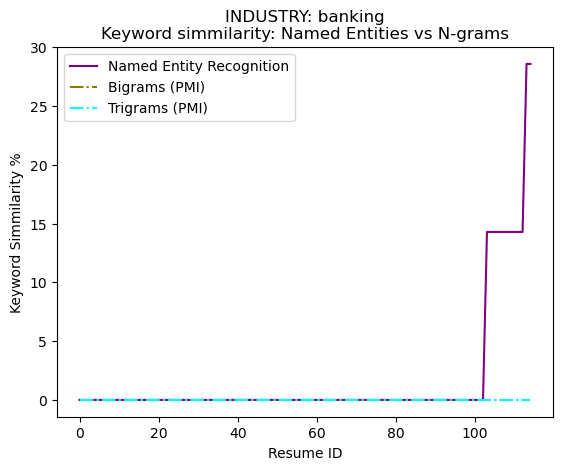

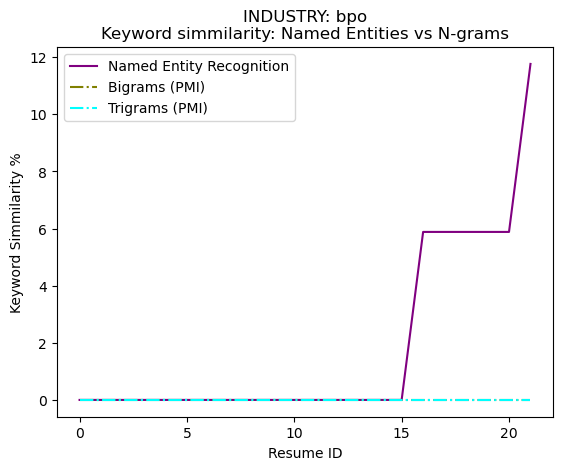

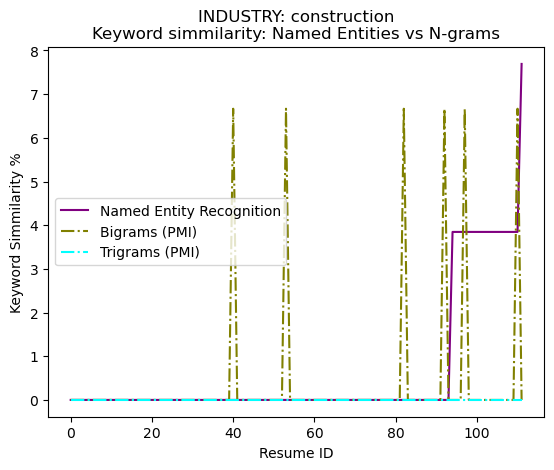

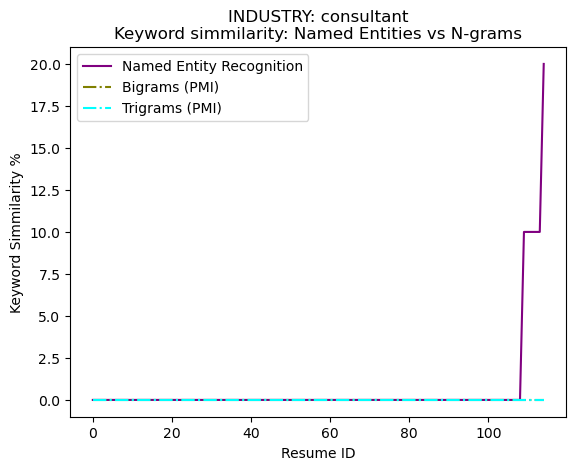

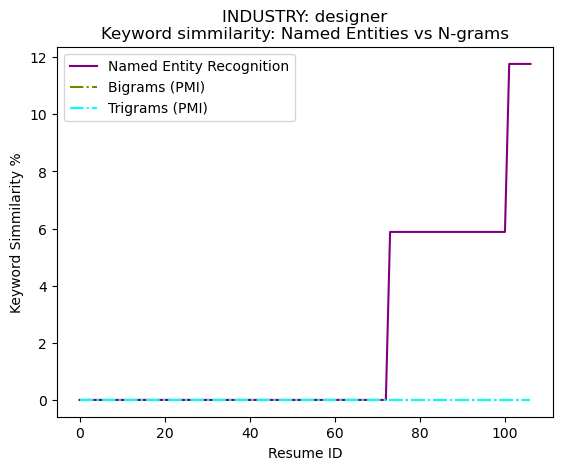

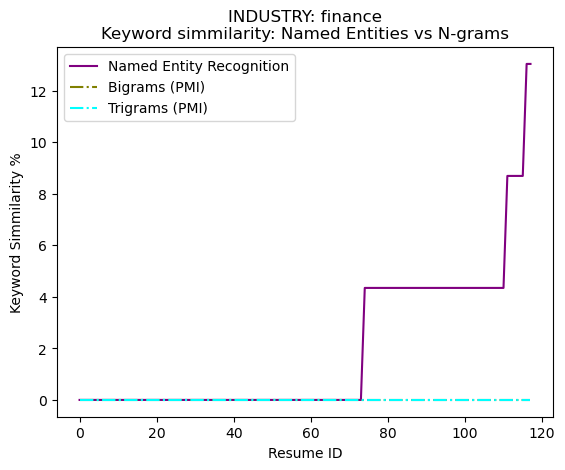

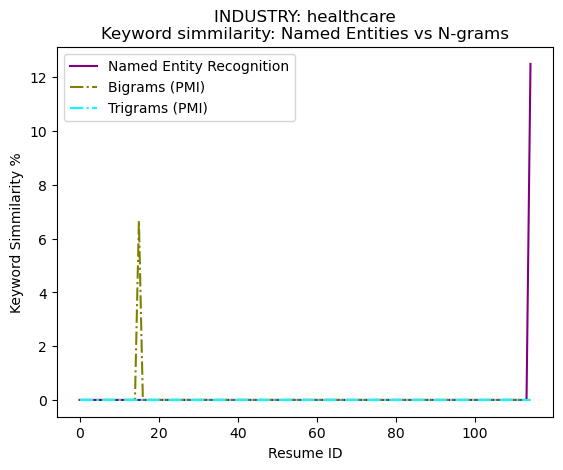

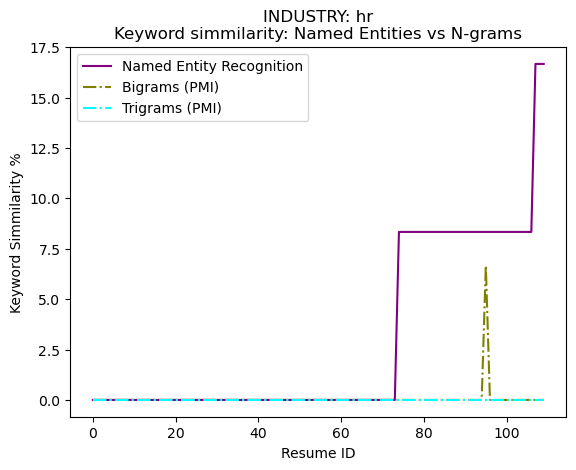

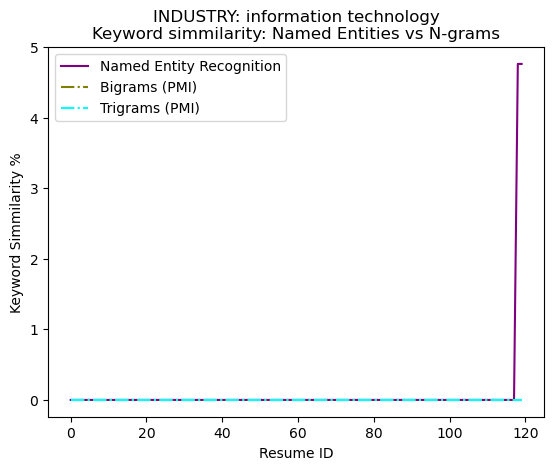

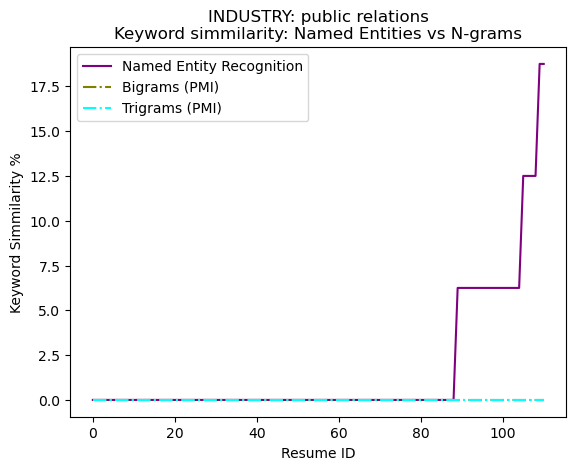

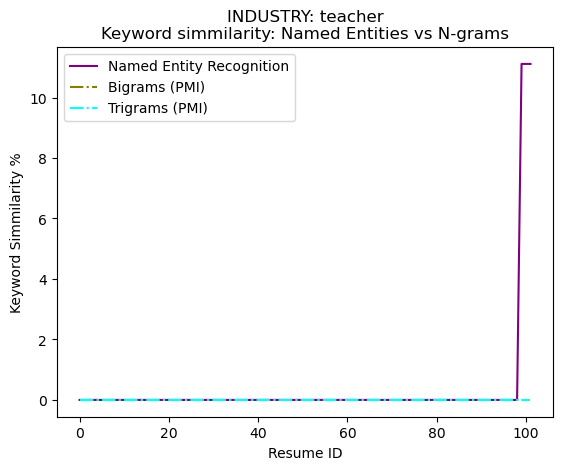

In [55]:
# Function to calculate the simmilarity between a job description text and a list of resumes
def get_simmilarity_lists(job_text, resumes):
    # calculate simmilarities using named entity recognition, bigram-trigram word collocations
    sims_named, sims_bigrams, sims_trigrams = [], [], []
    
    # loop through each resume
    for resume_text in resumes:
        # calculate verb simmilarities and save values
        sim_named, _, _ = get_simmilarity(resume_text, job_text, method='named_entity', print_=False)
        sim_bigram, _, _ = get_simmilarity(resume_text, job_text, method='bigram', print_=False)
        sim_trigram, _, _ = get_simmilarity(resume_text, job_text, method='trigram', print_=False)
        sims_named.append(sim_named)
        sims_bigrams.append(sim_bigram)
        sims_trigrams.append(sim_trigram)
    
    # return lists of simmilarities using each method
    return sims_named, sims_bigrams, sims_trigrams

# Function to plot the simmilarity lines
def plot_simmilarity_comparison(sims_named, sims_bigrams, sims_trigrams, title=''):
    # plot lines simmilarities (named entity, bigram, trigram)
    plt.plot(sims_named, color='purple', label='Named Entity Recognition')
    plt.plot(sims_bigrams, '-.', color='olive', label='Bigrams (PMI)')
    plt.plot(sims_trigrams, '-.', color='cyan', label='Trigrams (PMI)')
    plt.title(title + "Keyword simmilarity: Named Entities vs N-grams")
    plt.xlabel("Resume ID")
    plt.ylabel("Keyword Simmilarity %")
    plt.legend()
    plt.show()

# Function to calculate and compare all simmilarities between 1 random industry job description and all available resumes for that industry
def compare_keyword_simmilarities(df_resumes, df_jobs):
    # loop through industries
    for industry in df_resumes['profession'].unique():
        # take 1 random industry job description from dataset
        job_text = df_jobs[df_jobs['search_term'] == industry]['description_upper'].reset_index(drop=True)[0]
        # get all resumes from that industry
        resumes = df_resumes[df_resumes['profession'] == industry]['resume_upper'].reset_index(drop=True)
        
        # get simmilarities, sort them (for best visualization) and plot the visualizations
        sims_named, sims_bigrams, sims_trigrams = get_simmilarity_lists(job_text, resumes)
        sorted_sims = sorted(list(zip(sims_named, sims_bigrams, sims_trigrams)), key=lambda x: x[0])
        sorted_named = [sim[0] for sim in sorted_sims]
        sorted_bigrams = [sim[1] for sim in sorted_sims]
        sorted_trigrams = [sim[2] for sim in sorted_sims]
        plot_simmilarity_comparison(sorted_named, sorted_bigrams, sorted_trigrams, title='INDUSTRY: ' + industry + '\n')
            

compare_keyword_simmilarities(df_resumes, df_jobs)

From the resultant plots:
- Most industries are showing high keyword simmilarity (resume vs job description) using __named entity recognition__.
- When using __bigrams with PMI metric__ we get some interesting pikes suggesting that it could increase keyword simmilarity for certain resumes.
- However, when using __trigrams with PMI metric__ we get nearly 0% keyword simmilarity for most resumes from all industries. This may be due to the low probability of 3 consecutive words being repeated on both texts.

We will use __name entity__ as our keyword extraction approach. However, __showing the top bigrams and trigrams from the job description__ could be an interesting feature to the user for our final product.

### 6. Correcting spelling errors from resume

Another important feature for our tool is to correct spelling errors from the input resume __without affecting keywords (named entities)__.

To achieve this we try 2 approaches:
- __Speller class (autocorrect library)__
- __suggest function (pattern library)__

For this step we will need to work with the unclean (original) resume texts.

In [56]:
# retrieve one random resume on their original raw text format
test_resume = df_resumes['resume'][100]
test_resume[:100]

'ACCOUNTANT\nSummary\nPersonable education professional driven to inspire students to achieve personal '

In [57]:
from autocorrect import Speller

# function to correct spelling errors from text using 1st approach
def revise_text_using_speller(text, named_entities, print_=False):
    # tokenize input text
    tokens = word_tokenize(text)
    
    # decompose the named entities into a list of single words
    named_ents = []
    for named_entity in named_entities:
        named_ents += named_entity.split(' ')
    
    # instantiate speller class for English usage
    spell = Speller(lang='en')
    
    # loop through words and count number of corrections
    number_revisions = 0
    for i, word in enumerate(tokens):
        
        # revise the word only if it's not in the named entities and not all capitalized
        if word.isupper() or word in named_ents:
            continue
        revised_word = spell(word)
        
        # if word was corrected, increase counter and replace token
        if revised_word != word:
            number_revisions += 1
            tokens[i] = revised_word
            
            if print_: # print insights if required
                print(f"{word} --> {revised_word}")
    
    # return both number of corrections made and the revised text in tokens format
    if print_: print(f"- TOTAL CORRECTIONS: {number_revisions} -")
    return number_revisions, ' '.join(tokens)

named_entities = process_named_entities(get_named_entities(test_resume))
_ = revise_text_using_speller(test_resume, named_entities, print_=True)

Personable --> Personal
requisitions --> acquisitions
Audits --> Audit
reconciliations --> reconciliation
Organizes --> Organized
QA/Mobile --> A/Mobile
requisitions --> acquisitions
requisitions --> acquisitions
integrations --> integration
expedited --> expedite
Coordinated --> Coordinates
Coordinated --> Coordinates
reconciliations --> reconciliation
- TOTAL CORRECTIONS: 13 -


In [61]:
from pattern.en import suggest

# function to correct spelling errors from text using 2nd approach
def revise_text_using_suggest(text, named_entities, threshold=0.6, print_=False):
    # tokenize input text
    tokens = word_tokenize(text)
    
    # decompose the named entities into a list of single words
    named_ents = []
    for named_entity in named_entities:
        named_ents += named_entity.split(' ')
    
    # loop through words and count number of corrections
    number_revisions = 0
    for i, word in enumerate(tokens):
        
        # revise the word only if it's not in the named entities and not all capitalized
        if word.isupper() or word in named_ents:
            continue
        
        # find possible word suggestions
        suggestions = suggest(word)
        suggestions_words = [word[0] for word in suggestions]
        
        # if there are no suggestions, the original word is within the suggestions
        # or if the best suggestion metric is below certain threshold, then skip the correction
        if len(suggestions_words) == 0 or word in suggestions_words or suggestions[0][1] < threshold:
            continue
        revised_word = suggestions_words[0]
        
        # if word was corrected, increase counter and replace token
        if revised_word != word:
            number_revisions += 1
            tokens[i] = revised_word
            
            if print_: # print insights if required
                print(f"{word} --> ('{suggestions[0][0]}', {round(suggestions[0][1], 2)})")
    
    # return both number of corrections made and the revised text in tokens format
    if print_: print(f"- TOTAL CORRECTIONS: {number_revisions} -")
    return number_revisions, ' '.join(tokens)

named_entities = process_named_entities(get_named_entities(test_resume))
_ = revise_text_using_suggest(test_resume, named_entities, print_=True)

Personable --> ('Reasonable', 0.97)
Highlights --> ('Highlight', 1.0)
vendors --> ('vendor', 1.0)
inventory --> ('inventor', 0.6)
randomly --> ('random', 1.0)
Performs --> ('Perform', 0.68)
processed --> ('processes', 0.85)
demographic --> ('geographic', 1.0)
maximize --> ('minimize', 1.0)
Completes --> ('Complete', 0.85)
reconciliations --> ('reconciliation', 1.0)
Organizes --> ('Organized', 0.88)
Tester --> ('Fester', 1.0)
Audited --> ('United', 0.96)
localization --> ('localisation', 1.0)
releases --> ('release', 0.64)
regression --> ('repression', 1.0)
vendors --> ('vendor', 1.0)
vendors --> ('vendor', 1.0)
audits --> ('audit', 1.0)
Ensured --> ('Insured', 1.0)
vendors --> ('vendor', 1.0)
implementations --> ('implementation', 1.0)
integrations --> ('integration', 1.0)
trainings --> ('training', 1.0)
opting --> ('outing', 1.0)
efficiencies --> ('deficiencies', 1.0)
expedited --> ('expedite', 1.0)
Coordinated --> ('Coordinate', 0.83)
itinerary --> ('itinerant', 1.0)
Coordinated --> 

We have succesfully __implemented 2 methods to correct spelling errors within resumes__.

Let's __compare them__ using a bunch of resumes.

Due to the __high time complexity__ of the spell-correction approaches, we will test on 40 resume only (from 1 single industry).

In [62]:
# Function to calculate the simmilarity between a job description text and a list of resumes
def get_spell_correction_lists(resumes):
    # calculate number of corrections using both methods
    speller_results, suggest_results = [], []
    
    # loop through each resume
    for i, resume_text in enumerate(resumes):
        # print progress due to high time complexity
        print(f"Resume {i+1}/{len(resumes)}")
        
        # extract named entities from resume
        named_entities = process_named_entities(get_named_entities(resume_text))
        
        # calculate the number of corrections within the resume
        speller_corrections, _ = revise_text_using_speller(resume_text, named_entities)
        suggest_corrections, _ = revise_text_using_suggest(resume_text, named_entities)
        speller_results.append(speller_corrections)
        suggest_results.append(suggest_corrections)
    
    # return lists of # corrections from both methods
    return speller_results, suggest_results

# Function to plot the number of corrections using both methods
def plot_spelling_corrections(speller_results, suggest_results, title_prefix=''):
    # plot lines and set labels
    plt.plot(speller_results, color='green', label='# Corrections using Speller')
    plt.plot(suggest_results, '-.', color='orange', label='# Corrections using Suggest')
    plt.title(title_prefix + "Spelling Error Corrections: Spell class vs Suggest")
    plt.xlabel("Resume ID")
    plt.ylabel("# of corrections")
    plt.legend()
    plt.show()

# Function to calculate and compare the number of spelling corrections from a group of resumes using 2 different methods
def compare_spelling_corrections(df_resumes, industry='information technology', n_resumes=20):
    # get all resumes from the industry
    resumes = df_resumes[df_resumes['profession'] == industry]['resume'].reset_index(drop=True)[:n_resumes]

    # get number-of-corrections-made lists and plot the visualizations
    speller_results, suggest_results = get_spell_correction_lists(resumes)
    sorted_results = sorted(list(zip(speller_results, suggest_results)), key=lambda x: x[0])
    sorted_speller_results = [result[0] for result in sorted_results]
    sorted_suggest_results = [result[1] for result in sorted_results]
    plot_spelling_corrections(sorted_speller_results, sorted_suggest_results, title_prefix='INDUSTRY: ' + industry + '\n')
            

compare_spelling_corrections(df_resumes, n_resumes=20)

Resume 1/20
Resume 2/20
Resume 3/20
Resume 4/20
Resume 5/20
Resume 6/20
Resume 7/20
Resume 8/20
Resume 9/20
Resume 10/20
Resume 11/20
Resume 12/20
Resume 13/20
Resume 14/20
Resume 15/20
Resume 16/20
Resume 17/20
Resume 18/20
Resume 19/20
Resume 20/20


From the results:
- The use of __Suggest__ to correct spelling mistakes show an __increased number of corrections__ among the sample resumes.
- The use of __Speller__ to correct spelling mistakes show a __modest number of corrections__ among the resumes.

We decided to use Suggest function as our spelling correction main approach.

### 7. Resume sentiment analysis

Let's analyze the sentiment of the resume entries.

This will help users __identify the negative sentiment sentences__ and motivate them to change those entries.

To achieve our goal we will use the following:
- __Vader Sentiment Analyzer__

For this step we need the clean resume version but without affecting stopwords, punctuation, numbers or upper-case letters.

In [63]:
# clean the resumes texts without affecting stopwords, punctuation, numbers or upper-case letters
df_resumes['resume_sentiment'] = clean_text_column(df_resumes, 'resume', lowercase=False, stops=False, punctuations=False, numbers=False)
df_resumes[['resume_sentiment', 'profession']]

resume_sentiment  profession
0     ACCOUNTANT Summary Financial Accountant specia...  accountant
1     STAFF ACCOUNTANT Summary Highly analytical and...  accountant
2     ACCOUNTANT Professional Summary To obtain a po...  accountant
3     SENIOR ACCOUNTANT Experience Company Name June...  accountant
4     SENIOR ACCOUNTANT Professional Summary Senior ...  accountant
...                                                 ...         ...
2479  READING TEACHER Summary I am a highly motivate...     teacher
2480  HISTORY TEACHER Professional Summary To be emp...     teacher
2481  TEACHER Summary Highly ethical, dependable, an...     teacher
2482  TEACHER Summary Talented early education profe...     teacher
2483  Kpandipou Koffi Summary Compassionate teaching...     teacher

[2484 rows x 2 columns]

In [64]:
# pick a random resume to test our sentiment analysis
test_resume = df_resumes['resume_sentiment'][850]
test_resume[:100]

'DIRECTOR OF BUSINESS DEVELOPMENT Summary Looking for the greatest opportunity to use my years of exp'

In [65]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to evaluate the sentiment of each resume entry
def evaluate_sentiment(resume_text, method='neg', negativity_threshold = 0.05, print_=False):
    
    # sentences tokenize the resume text
    sentence_tokens = sent_tokenize(resume_text)
    
    # instantiate the Sentiment Analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # loop through sentences and evaluate their sentiment
    negative_entries = []
    for i, sentence in enumerate(sentence_tokens):
        # calculate the sentiment metrics of the sentence
        sentiment_dict = analyzer.polarity_scores(sentence)
        
        # approach 1: using only negative metric --> save the sentence if it's above a threshold
        if method == 'neg' and sentiment_dict['neg'] >= negativity_threshold:
            negative_entries.append((sentiment_dict['neg'], sentence))
            
        # approach 2: using compund metric --> save the sentence if it's below a threshold
        if method == 'compound' and sentiment_dict['compound'] <= negativity_threshold:
            negative_entries.append((sentiment_dict['compound'], sentence))
        
        if print_: # print insights if required
            print(f"Entry {i+1} sentiment: {sentiment_dict}")
    
    # return identified negative entries sorted by metric
    return sorted(negative_entries, key = lambda x:x[0], reverse= method == 'neg')

# Test our function with a sample resume and both metrics
print("-- Resume Sentiment using NEGATIVE metric: --")
display(evaluate_sentiment(test_resume, print_=True, method='neg', negativity_threshold=0.1))
print("-- Resume Sentiment using COMPOUND metric: --")
display(evaluate_sentiment(test_resume, print_=False, method='compound', negativity_threshold=-0.1))

-- Resume Sentiment using NEGATIVE metric: --
Entry 1 sentiment: {'neg': 0.0, 'neu': 0.773, 'pos': 0.227, 'compound': 0.8748}
Entry 2 sentiment: {'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'compound': 0.5994}
Entry 3 sentiment: {'neg': 0.0, 'neu': 0.895, 'pos': 0.105, 'compound': 0.25}
Entry 4 sentiment: {'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'compound': 0.25}
Entry 5 sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Entry 6 sentiment: {'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'compound': 0.3182}
Entry 7 sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Entry 8 sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Entry 9 sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Entry 10 sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Entry 11 sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Entry 12 sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Entry 13 sentiment: {'neg': 0.1, 'neu': 0.9,

[(0.175,
  'Successful implementation of Corporate policies and procedures at all locations and City office, creating more efficient revenue controls and immediate reduction of liabilities and risk of financial losses.'),
 (0.148,
  'Responsible for budget preparation and analysis of Profit and Loss Statements.'),
 (0.107,
  'Developed positive relationships with "high risk" clients through daily contact and various departments within the area.'),
 (0.1,
  'Management oversight of approximately 80 locations throughout the Bay Area encompassing San Francisco, Oakland-East Bay, San Jose and Marin County; over $65 Million dollars in gross parking revenues annually.')]

-- Resume Sentiment using COMPOUND metric: --


[(-0.4767,
  'Management oversight of approximately 80 locations throughout the Bay Area encompassing San Francisco, Oakland-East Bay, San Jose and Marin County; over $65 Million dollars in gross parking revenues annually.')]

Let's __compare number of negative entries using both metrics:__
- negative (above a certain threshold)
- compound (below a threshold)

using a large group of resumes.

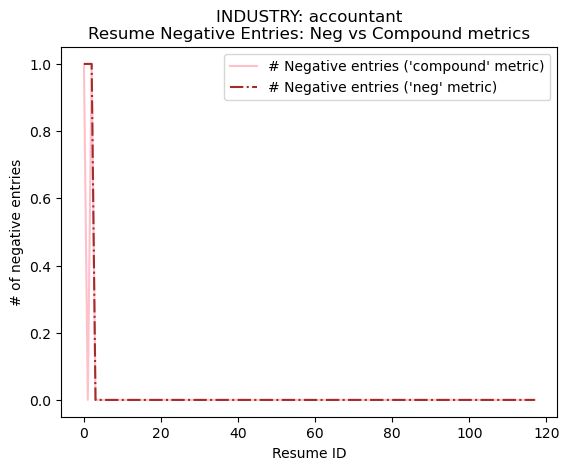

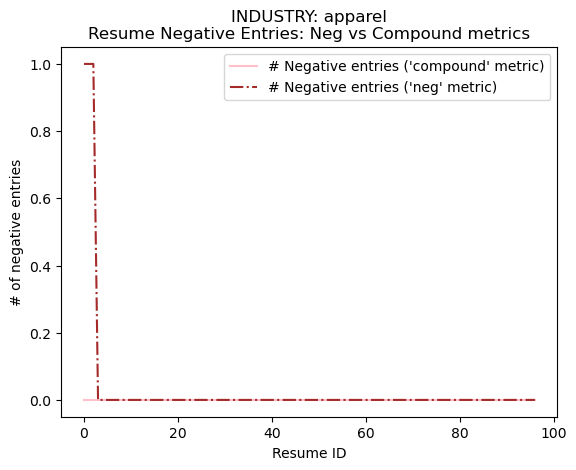

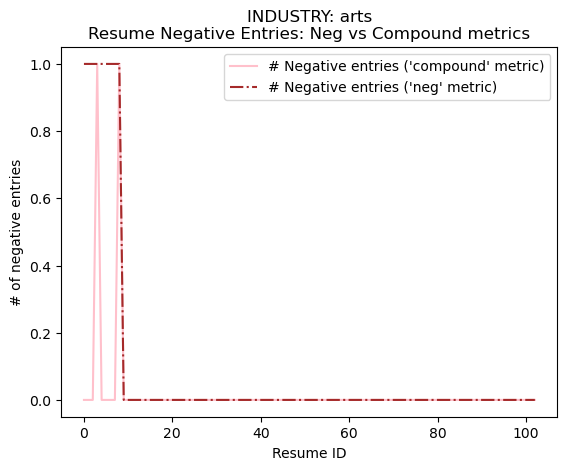

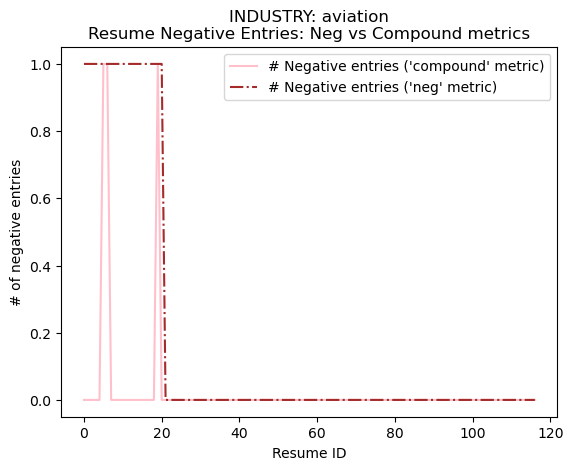

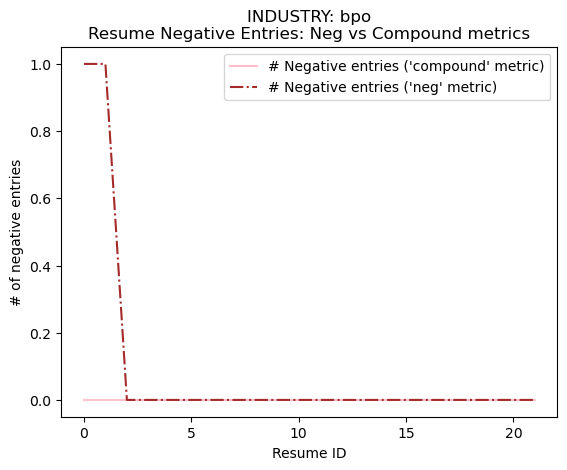

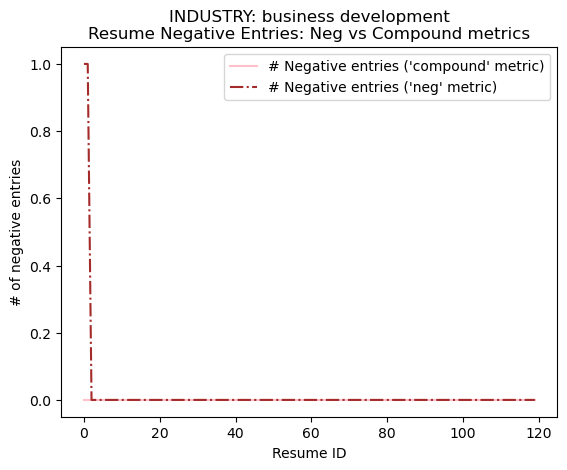

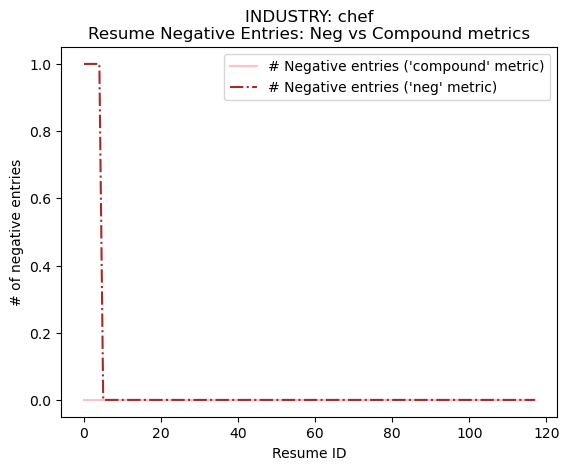

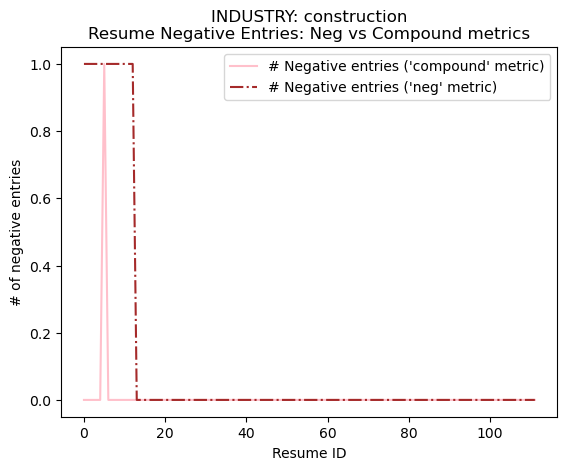

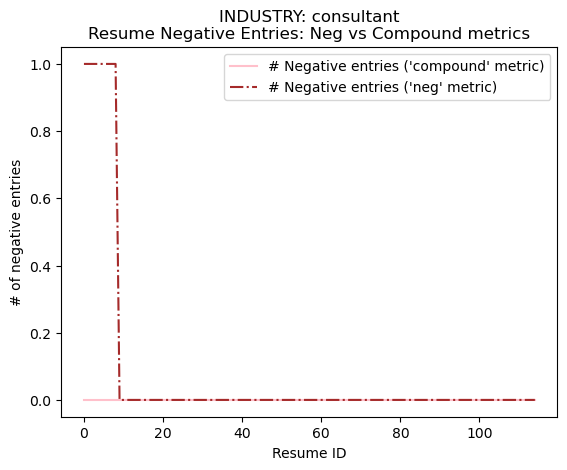

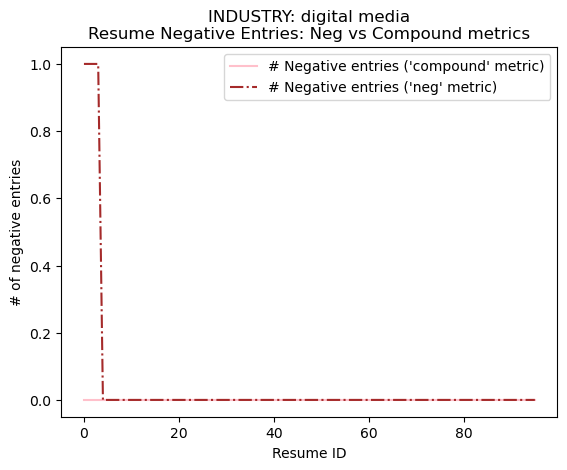

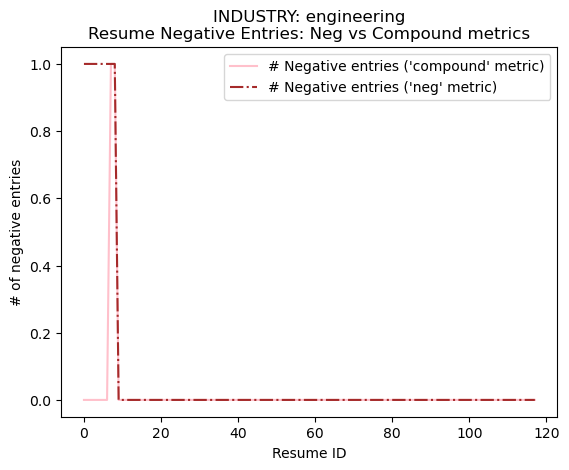

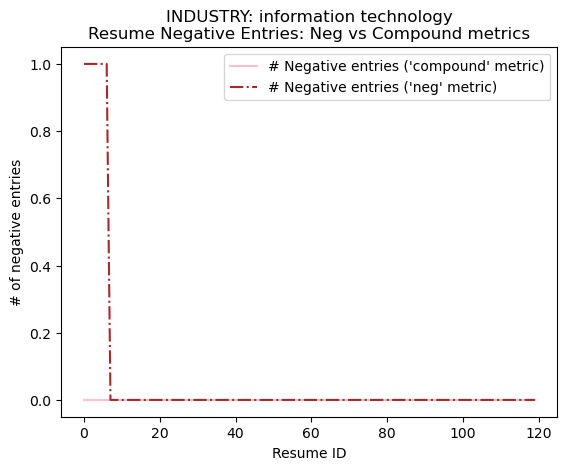

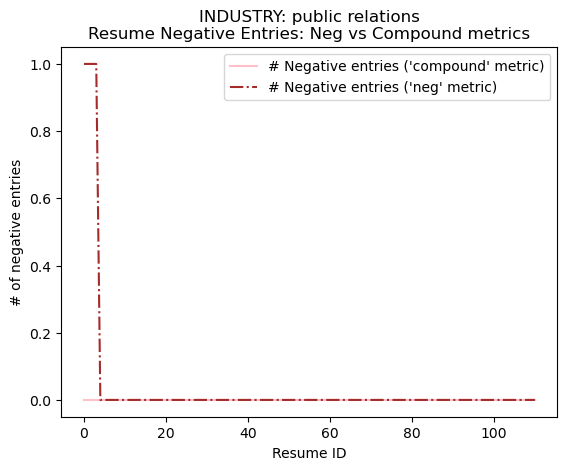

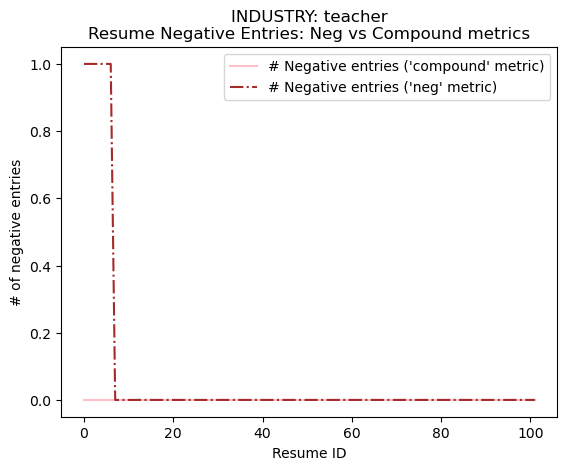

In [66]:
# Function to calculate the number of negative entries from a group of resumes (using 2 metrics)
def get_negative_entries_lists(resumes):
    # calculate number of negative entries using both metrics from sentiment analysis
    neg_results, compound_results = [], []
    
    # loop through each resume
    for i, resume_text in enumerate(resumes):
        
        # calculate the number of negative entries within the resume
        neg_entries = len(evaluate_sentiment(resume_text, method='neg', negativity_threshold=0.05))
        compound_entries = len(evaluate_sentiment(resume_text, method='compound', negativity_threshold=-0.05))
        neg_results.append(neg_entries)
        compound_results.append(compound_entries)
    
    # return lists of # of negative entries using both metrics
    return neg_results, compound_results

# Function to plot the number of negative entries using both metrics
def plot_negative_entries(neg_results, compound_results, title_prefix=''):
    # plot lines and set labels
    plt.plot(compound_results, color='pink', label="# Negative entries ('compound' metric)")
    plt.plot(neg_results, '-.', color='brown', label="# Negative entries ('neg' metric)")
    plt.title(title_prefix + "Resume Negative Entries: Neg vs Compound metrics")
    plt.xlabel("Resume ID")
    plt.ylabel("# of negative entries")
    plt.legend()
    plt.show()

# Function to calculate and compare the number of negative entries from a group of resumes using 2 different metrics
def compare_negative_entries(df_resumes, df_jobs):
    # loop through industries
    for industry in df_resumes['profession'].unique():
        
        # take 1 random job description from dataset from the industry
        job_text = df_jobs[df_jobs['search_term'] == industry]['description_upper'].reset_index(drop=True)[0]
        
        # get all resumes from that industry
        resumes = df_resumes[df_resumes['profession'] == industry]['resume_upper'].reset_index(drop=True)
        
        # get simmilarities, sort them (for best visualization) and plot the visualizations
        neg_results, compound_results = get_negative_entries_lists(resumes)
        sorted_results = sorted(list(zip(neg_results, compound_results)), key=lambda x: x[0], reverse=True)
        sorted_neg = [result[0] for result in sorted_results]
        sorted_compound = [result[1] for result in sorted_results]
        plot_negative_entries(sorted_neg, sorted_compound, title_prefix='INDUSTRY: ' + industry + '\n')

compare_negative_entries(df_resumes, df_jobs)

__Results:__
- The __'neg'__ metric shows more stability when identifying the number of negative netries within a resume.
- The __'compound'__ metric shows some spikes for certain resumes, but overall less entries identified than 'neg'.
- Overall, __most of the resume does not contain negative entries__, even given the fact that we used a low __threshold that should maximize the number of negative sentences identified__.

From this results, we decided to __use the 'neg' metric for negative sentences identification.__

## 8. Calculating simmilarity between each Job Description & Resume entry

One of the most important features for our project is to __calculate the simmilarity between each Job Description & Resume entry__.

To achieve this we have to vectorize each of the sentences of both resume and job description, calculate the matrixes and pairwise simmilarity between each possible pair of sentences.

For vectorization we will test the following techniques:
- __Bag of Words__
- __TF-IDF__

Then we will be able to calculate the __pairwise simmilarity__.

In [67]:
# pick a random resume for testing
industry = 'information technology'
test_resume = df_resumes[df_resumes['profession'] == industry]['resume'].reset_index(drop=True)[10]
test_resume[:100]

'INFORMATION TECHNOLOGY (IT) SPECIALIST\nExperience\nInformation Technology (IT) Specialist\n \nJanuary 2'

In [68]:
# pick a random job description for testing
test_job = df_jobs[df_jobs['search_term'] == industry]['description'].reset_index(drop=True)[10]
test_job[:100]

'Reporting to the Chief Innovation & Technology Officer, this role plans, directs, leads, and manages'

In [69]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# function to clean a simple string/text using our previously defined class
def clean_text(text, stops=True, numbers=True, punctuations=True, whitespaces=True, lowercase=True):
    # instantiate our text cleaning class
    tc = TextCleaning()
    clean_text = text
    
    # perform actions depending on each flags
    if lowercase:
        clean_text = clean_text.lower()
    if stops: 
        clean_text = tc.remove_stopwords(clean_text)
    if numbers:
        clean_text = tc.remove_numbers(clean_text)
    if punctuations:
        clean_text = tc.remove_punctuation(clean_text)
    if whitespaces:
        clean_text = tc.remove_whitespaces(clean_text)
        
    return clean_text # return clean text

# function to vectorize a text using TF-IDF
def vectorize_text_entries(text, method='tfidf'):
    
    # sentence tokenize the input text
    sentence_tokens = sent_tokenize(text)
    
    # clean the sentence
    sentence_tokens = list(map(clean_text, sentence_tokens))
    
    # instantiate vectorization method class
    if method == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1, stop_words="english")
    elif method =='bow':
        vectorizer = CountVectorizer(min_df=1, stop_words="english")
    
    # vectorize sentences and return the dataframe
    feature_matrix = vectorizer.fit_transform(sentence_tokens)
    col_names = vectorizer.get_feature_names_out()
    arr = feature_matrix.toarray()
    df_text = pd.DataFrame(arr, columns = col_names)
    
    return df_text

# this function concats (vertically) 2 dataframes
# but returns only the columns from df1 and rows from df2
def concat_dataframes_df1_columns_df2_rows(df1, df2):
    
    # concatenate both dataframes
    df_concat = pd.concat([df1, df2], ignore_index=True)
    
    # fill missing values with zeroes
    df_concat = df_concat.fillna(0.0)
    
    # select only columns from df1
    df_concat =  df_concat.iloc[:, : df1.shape[1]]
    
    # select only rows from df2
    df_concat = df_concat.iloc[-len(df2):]
    
    df_concat.reset_index(drop=True, inplace=True)
    
    return df_concat

# test vectorization of job description uising TF-IDF
df_job = vectorize_text_entries(test_job, method='tfidf')
print("Shape:", df_job.shape)
df_job.tail()

Shape: (85, 571)


abilities  access  accessibility  accessible  accommodation  \
80        0.0     0.0            0.0         0.0            0.0   
81        0.0     0.0            0.0         0.0            0.0   
82        0.0     0.0            0.0         0.0            0.0   
83        0.0     0.0            0.0         0.0            0.0   
84        0.0     0.0            0.0         0.0            0.0   

    accountability  accountable  accurate  achieve  achievement  ...  way  \
80             0.0          0.0       0.0      0.0          0.0  ...  0.0   
81             0.0          0.0       0.0      0.0          0.0  ...  0.0   
82             0.0          0.0       0.0      0.0          0.0  ...  0.0   
83             0.0          0.0       0.0      0.0          0.0  ...  0.0   
84             0.0          0.0       0.0      0.0          0.0  ...  0.0   

    work  workers  workforce  working  workplace  works      wsib  wsibonca  \
80   0.0      0.0        0.0      0.0        0.0    0.0  0.176160   0.28612   
81   0.0      0.0        0.0      0.0        0.0    0.0  0.000000   0.00000   
82   0.0      0.0        0.0      0.0        0.0    0.0  0.169463   0.00000   
83   0.0      0.0        0.0      0.0        0.0    0.0  0.000000   0.00000   
84   0.0      0.0        0.0      0.0        0.0    0.0  0.000000   0.00000   

    years  
80    0.0  
81    0.0  
82    0.0  
83    0.0  
84    0.0  

[5 rows x 571 columns]

In [70]:
# test vectorization of job description uising Bag of Words
df_job = vectorize_text_entries(test_job, method='bow')
print("Shape:", df_job.shape)
df_job.tail()

Shape: (85, 571)


abilities  access  accessibility  accessible  accommodation  \
80          0       0              0           0              0   
81          0       0              0           0              0   
82          0       0              0           0              0   
83          0       0              0           0              0   
84          0       0              0           0              0   

    accountability  accountable  accurate  achieve  achievement  ...  way  \
80               0            0         0        0            0  ...    0   
81               0            0         0        0            0  ...    0   
82               0            0         0        0            0  ...    0   
83               0            0         0        0            0  ...    0   
84               0            0         0        0            0  ...    0   

    work  workers  workforce  working  workplace  works  wsib  wsibonca  years  
80     0        0          0        0          0      0     1         1      0  
81     0        0          0        0          0      0     0         0      0  
82     0        0          0        0          0      0     1         0      0  
83     0        0          0        0          0      0     0         0      0  
84     0        0          0        0          0      0     0         0      0  

[5 rows x 571 columns]

In [71]:
# test vectorization of resume
df_resume = vectorize_text_entries(test_resume, method='tfidf')
print("Shape:", df_resume.shape)
df_resume.tail()

Shape: (38, 402)


aas  acceptance  according  accurately  acquisition  activities  \
33  0.000000    0.000000        0.0         0.0          0.0         0.0   
34  0.000000    0.000000        0.0         0.0          0.0         0.0   
35  0.000000    0.000000        0.0         0.0          0.0         0.0   
36  0.000000    0.234492        0.0         0.0          0.0         0.0   
37  0.065948    0.000000        0.0         0.0          0.0         0.0   

    adequacies  administrative    agency       ags  ...  validation   various  \
33         0.0        0.189668  0.000000  0.000000  ...    0.000000  0.000000   
34         0.0        0.000000  0.000000  0.000000  ...    0.000000  0.000000   
35         0.0        0.000000  0.000000  0.000000  ...    0.000000  0.283252   
36         0.0        0.000000  0.000000  0.000000  ...    0.000000  0.000000   
37         0.0        0.054435  0.054435  0.065948  ...    0.059213  0.000000   

    vis     vista    visual     voice  weekly  work  worked   ï¼  
33  0.0  0.000000  0.000000  0.166202     0.0   0.0     0.0  0.0  
34  0.0  0.000000  0.000000  0.000000     0.0   0.0     0.0  0.0  
35  0.0  0.000000  0.263966  0.248208     0.0   0.0     0.0  0.0  
36  0.0  0.000000  0.000000  0.205480     0.0   0.0     0.0  0.0  
37  0.0  0.059213  0.000000  0.047700     0.0   0.0     0.0  0.0  

[5 rows x 402 columns]

In [72]:
# test retrieving only columns (words) from job description that were present in resume vectorized
# rows = rows from resume, columns = columns from job description
df_resume_2 = concat_dataframes_df1_columns_df2_rows(df_job, df_resume)
print("Shape:", df_resume_2.shape)
df_resume_2.tail()

Shape: (38, 571)


abilities  access  accessibility  accessible  accommodation  \
33        0.0     0.0            0.0         0.0            0.0   
34        0.0     0.0            0.0         0.0            0.0   
35        0.0     0.0            0.0         0.0            0.0   
36        0.0     0.0            0.0         0.0            0.0   
37        0.0     0.0            0.0         0.0            0.0   

    accountability  accountable  accurate  achieve  achievement  ...  way  \
33             0.0          0.0       0.0      0.0          0.0  ...  0.0   
34             0.0          0.0       0.0      0.0          0.0  ...  0.0   
35             0.0          0.0       0.0      0.0          0.0  ...  0.0   
36             0.0          0.0       0.0      0.0          0.0  ...  0.0   
37             0.0          0.0       0.0      0.0          0.0  ...  0.0   

    work  workers  workforce  working  workplace  works  wsib  wsibonca  years  
33   0.0      0.0        0.0      0.0        0.0    0.0   0.0       0.0    0.0  
34   0.0      0.0        0.0      0.0        0.0    0.0   0.0       0.0    0.0  
35   0.0      0.0        0.0      0.0        0.0    0.0   0.0       0.0    0.0  
36   0.0      0.0        0.0      0.0        0.0    0.0   0.0       0.0    0.0  
37   0.0      0.0        0.0      0.0        0.0    0.0   0.0       0.0    0.0  

[5 rows x 571 columns]

In [73]:
import spicy

# function to compute the pairwise simmilarities between each resume entry and each job description entry
def get_simmilarity_matrix(df1, df2, print_=False): # df1 = job, df2 = resume
    
    # get the numeric values from the dataframes
    matrix_1 = spicy.sparse.csr_matrix(df1.values)
    matrix_2 = spicy.sparse.csr_matrix(df2.values)
    
    # compute the pairwise simmilarity matrix
    simmilarity_matrix = matrix_1 * matrix_2.T
    
    if print_: # print the matrix if required
        display(simmilarity_matrix.todense())
        
    return matrix_1, matrix_2, simmilarity_matrix

# get matrix simmilarity
matrix_job, _, matrix_simmilarity = get_simmilarity_matrix(df_job, df_resume_2, print_=True)

D:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


matrix([[0.2460574 , 0.49196464, 0.21143074, ..., 0.        , 0.        ,
         0.23849975],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.18983909, ..., 0.65127567, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [74]:
# function to get the best simmilarities row-wise from a matrix
def get_best_pairwise_simmilarities(matrix_job, matrix_simmilarity):
    best_simmilarities = []
    
    # loop through job description sentences and find the resume entry with most simmilarity to that sentence
    for i in range(matrix_job.shape[0]):
        
        # save the simmilarities between the job sentence and each resume sentence
        row_values = [matrix.item(i) for matrix in matrix_simmilarity.todense().T]
        
        # get the max simmilarity (and index) between the job sentence and each resume sentence
        max_simmilarity = max(row_values)
        max_index = row_values.index(max_simmilarity)
        
        # append index and value of the max simmilarity of the job sentence
        best_simmilarities.append((max_index, max_simmilarity))

    return best_simmilarities

# get best simmilarity from the resume for each job description entry
best_simmilarities = get_best_pairwise_simmilarities(matrix_job, matrix_simmilarity)
best_simmilarities[:15]

[(11, 0.712522703741693),
 (4, 0.3663896406106269),
 (17, 0.7757208947579497),
 (11, 0.8386822303161815),
 (19, 0.6567302619356536),
 (19, 0.7243019990791614),
 (15, 0.44439626451698977),
 (17, 0.350766603470892),
 (29, 0.44302340443183935),
 (12, 0.39940983716445816),
 (11, 0.27956074343872717),
 (15, 0.22219813225849488),
 (34, 0.8721861854722481),
 (3, 0.5031466596344438),
 (15, 0.44439626451698977)]

In [75]:
# function to save the best simmilarities found
def get_best_simmilarities_per_job_sentence(test_job, test_resume, best_simmilarities, method, print_=False):
    
    # tokenize sentences from resume
    resume_sentences = sent_tokenize(test_resume)
    
    # tokenize and loop through the sentences of the job description
    entries = []
    for i, sentence in enumerate(sent_tokenize(test_job)):
        
        # get the best simmilarity found for the job description sentence
        simmilarity = best_simmilarities[i][1]
        
        # get the index of the resume sentence with the best simmilarity to the job description sentence
        index = best_simmilarities[i][0]
        
        # clean both sentences from job and resume
        clean_job_sentence = clean_text(sentence, stops=False, numbers=False, punctuations=False, lowercase=False)
        clean_resume_sentence = clean_text(resume_sentences[index], stops=False, numbers=False, punctuations=False, lowercase=False)
        
        # display results
        if print_:
            print(f'{i+1}. Job description entry:\t  "{clean_job_sentence[:100]}"')
            display_simmilarity = f"{simmilarity}" if method == 'bow' else f"{round(simmilarity * 100, 2)} %"
            print("- % Best simmilarity:\t\t ", display_simmilarity)
            print('- Resume entry that best matches: "' + clean_resume_sentence[:100] if simmilarity != 0.0 else "NOT FOUND")
            print("-"*30)
            
        # save results
        entries.append((clean_job_sentence, round(simmilarity * 100, 2), clean_resume_sentence if simmilarity != 0.0 else "NOT FOUND"))
    return entries

In [76]:
def calculate_simmilarity_resume_vs_job_entries(test_job, test_resume, method, display_=False):
    # vectorize both job description and resume
    df_job = vectorize_text_entries(test_job, method=method)
    df_resume = vectorize_text_entries(test_resume, method=method)
    
    # further process vectorized resume to get only columns (words) present in job description
    df_resume_2 = concat_dataframes_df1_columns_df2_rows(df_job, df_resume)
    
    # calculate matrix of simmilarities
    matrix_job, _, matrix_simmilarity = get_simmilarity_matrix(df_job, df_resume_2)
    
    # get best simmilarity from resume per each job sentence
    best_simmilarities = get_best_pairwise_simmilarities(matrix_job, matrix_simmilarity)
    
    # get the final results (and show them if required)
    return get_best_simmilarities_per_job_sentence(test_job, test_resume, best_simmilarities, method=method, print_=display_)
    
_ = calculate_simmilarity_resume_vs_job_entries(test_job, test_resume, method='tfidf', display_=True)

1. Job description entry:	  "Reporting to the Chief Innovation & Technology Officer, this role plans, directs, leads, and manages"
- % Best simmilarity:		  8.42 %
- Resume entry that best matches: "Obtained contract engineering services by developing the Acquisition Requirements Package (ARP), and
------------------------------
2. Job description entry:	  "This role works with other jurisdictions (federal, provincial and municipal) to share cyber security"
- % Best simmilarity:		  5.24 %
- Resume entry that best matches: "Provided engineering, procurement, installation, cutover and testing requirements for the High Frequ
------------------------------
3. Job description entry:	  "It is also responsible for overseeing the development and management of disaster recovery plans for "
- % Best simmilarity:		  15.04 %
- Resume entry that best matches: "These efforts included various secure voice, data, and visual information systems critical to the Co
------------------------------
4. Job de

__We managed to find the best resume sentence match per job description sentence.__

Let's __compare results using both methods BoW and TF-IDF.__

In [77]:
# Function to calculate the simmilarities using BoW and TF-IDF between 1 resume and 1 job description
def get_entry_simmilarity_lists(text_job, text_resume):
    # get pairwise simmilarity using bow and tf-idf
    simmilarities_bow = calculate_simmilarity_resume_vs_job_entries(test_job, test_resume, method='bow')
    simmilarities_tfidf = calculate_simmilarity_resume_vs_job_entries(test_job, test_resume, method='tfidf')
    
    # get the actual numbers (simmilarities) from the function return value
    simmilarities_bow = [sim[1] for sim in simmilarities_bow]
    simmilarities_tfidf = [sim[1] for sim in simmilarities_tfidf]
    
    # scale the simmilarities so that the plots make sense
    max_bow = max(simmilarities_bow)
    simmilarities_bow = [sim/max_bow for sim in simmilarities_bow]
    max_tfidf = max(simmilarities_tfidf)
    simmilarities_tfidf = [sim/max_tfidf for sim in simmilarities_tfidf]
    
    # sort the simmilarity values for better visualization
    sorted_sims = sorted(list(zip(simmilarities_bow, simmilarities_tfidf)), key= lambda x:x[0], reverse=True)
    sorted_bow = [sim[0] for sim in sorted_sims]
    sorted_tfidf = [sim[1] for sim in sorted_sims]
    
    # return sorted simmilarities
    return sorted_bow, sorted_tfidf

# Function to plot the number of negative entries using both metrics
def plot_entry_simmilarity(simmilarities_bow, simmilarities_tfidf, title_prefix=''):
    # plot lines and set labels
    plt.plot(simmilarities_bow, color='lime', label="Sentence Cos Simmilarity (BoW)")
    plt.plot(simmilarities_tfidf, '-.', color='k', label="Sentence Cos Simmilarity (TF-IDF)")
    plt.title(title_prefix + "Cosine Simmilarity (per sentence): Resume vs Job Description")
    plt.xlabel("Job Description Sentence ID")
    plt.ylabel("Best Simmilarity from a Resume Sentence")
    plt.legend()
    plt.show()

plot_entry_simmilarity(*get_entry_simmilarity_lists(test_job, test_resume))

__Results:__
- Using TF-IDF method allows us to find better cosine simmilarity between the job description sentence and the best matching sentence of the resume.
- Few cases where BoW shows a better cosine simmilarity. This occurs on the very first sentences of the job description (which contains company information).
- The requirements (later sentences around 40-80) contain best matches using TF-IDF.

For these reasons we will use TF-IDF as our vectorization method.

### 9. Classification Models

Let's __classify our resumes based on the profession__ or job they are trying to apply.

This will help us to __identify the industry from the user input resume__, and possibly recommend an example ideal resume from that industry.

We will start with:

- __Feature extraction (extract most common words from resume)__

In [78]:
from nltk import FreqDist

# function to extract most frequent features from the clean resumes
def extract_features_from_resumes(df_resumes, n_features=100, print_=False):
    
    # loop through industries from the resumes
    features = []
    for industry in df_resumes['profession'].unique():
        
        # filter resumes (clean text version) per industry
        filter_industry = df_resumes['profession'] == industry
        resumes = df_resumes[filter_industry]['resume_clean']

        # unify all resumes text into a single corpus
        resume_corpus = ""
        for resume in resumes:
            resume_corpus += resume
        
        # extract top 100 frequent words from the resume corpus (of the current industry)
        counter_dict = FreqDist(word_tokenize(resume_corpus))
        features_extracted = counter_dict.most_common(n_features)
        if print_:
            print(f"-- Features extracted from industry: {industry.upper()} --")
            print(features_extracted)
        
        # save extracted features from the industry
        features += [feature[0] for feature in features_extracted if feature[0] != 'industry']
        
    # return unique extracted features (words)
    return list(set(features))

extracted_features = extract_features_from_resumes(df_resumes, print_=True)

-- Features extracted from industry: ACCOUNTANT --
[('accounting', 1203), ('financial', 1068), ('accounts', 787), ('state', 764), ('company', 748), ('city', 678), ('management', 577), ('name', 546), ('reports', 470), ('accountant', 455), ('tax', 429), ('monthly', 421), ('general', 379), ('business', 369), ('skills', 352), ('payroll', 350), ('analysis', 344), ('ï¼\u200b', 338), ('cash', 323), ('reporting', 321), ('account', 315), ('ledger', 304), ('bank', 297), ('statements', 294), ('office', 282), ('sales', 253), ('system', 244), ('including', 235), ('prepare', 233), ('experience', 232), ('entries', 226), ('budget', 223), ('prepared', 223), ('reconciliations', 219), ('information', 219), ('s', 217), ('customer', 216), ('process', 214), ('new', 210), ('preparation', 208), ('payable', 207), ('software', 204), ('reconciliation', 204), ('staff', 204), ('responsible', 201), ('balance', 199), ('microsoft', 198), ('work', 196), ('finance', 192), ('procedures', 192), ('excel', 189), ('inventor

In [79]:
# size of total extracted features from all industries
len(extracted_features)

480

In [80]:
# choose accountant resume for testing
test_resume = df_resumes['resume_clean'][0]

In [81]:
# function to set the features of 1 particular resume from a list of extracted features
def search_features(text, extracted_features):
    
    # tokenize the text and get unique words
    tokens = set(word_tokenize(text))
    
    # loop through the extracted features
    text_features = {}
    for feature in extracted_features:
        
        # set the feature in True if it's present in the text
        text_features[feature] = (feature in tokens)
        
    # return dictionary of features
    return text_features

# test our function, make it a list just for visualization (slicing) purposes
list(search_features(test_resume, extracted_features).items())[:20]

[('network', True),
 ('nutrition', False),
 ('â·', False),
 ('create', False),
 ('infrastructure', False),
 ('cash', True),
 ('specialist', False),
 ('installation', False),
 ('fitness', False),
 ('relationships', False),
 ('bachelor', False),
 ('department', True),
 ('budget', True),
 ('agriculture', False),
 ('proper', False),
 ('coordinated', True),
 ('teaching', False),
 ('bpo', False),
 ('duties', False),
 ('phone', False)]

Now that we have extracted our features,

let's __set the features of each resume and their corresponding labels__.

In [82]:
# function to build the dataset from resumes and extracted features
def get_dataset(df_resumes, extracted_features):
    
    # loop through the clean text resumes and the targets (profession/industry)
    dataset = []
    for i, row in df_resumes[['resume_clean', 'profession']].iterrows():
        
        # set the resume and industry from the row
        resume, industry = row[0], row[1]
        
        # set the feature values from the resume text and previously extracted features
        features = search_features(resume, extracted_features)
        
        # set the target
        features['industry'] = industry
        
        # append the features + target to the dataset
        dataset.append(features)
    
    # convert the dataset (list of dictionaries) into a pandas Dataframe
    df = pd.DataFrame(dataset)
    
    # move target column (industry) to the last
    df = df[[col for col in df if col != 'industry'] + ['industry']]
    return df

df = get_dataset(df_resumes, extracted_features)

In [83]:
print("Dataset shape:", df.shape)
df

Dataset shape: (2484, 481)


network  nutrition     â·  create  infrastructure   cash  specialist  \
0        True      False  False   False           False   True       False   
1       False      False  False   False           False   True       False   
2       False      False  False   False           False   True        True   
3       False      False  False   False           False   True       False   
4        True      False  False   False           False   True       False   
...       ...        ...    ...     ...             ...    ...         ...   
2479    False      False  False   False           False  False       False   
2480    False      False  False   False           False  False       False   
2481    False      False  False   False           False  False       False   
2482    False      False  False   False           False  False       False   
2483    False      False  False    True           False  False       False   

      installation  fitness  relationships  ...  administrative  classes  \
0            False    False          False  ...           False    False   
1            False    False          False  ...           False    False   
2            False    False          False  ...            True    False   
3            False    False           True  ...           False    False   
4            False    False          False  ...           False    False   
...            ...      ...            ...  ...             ...      ...   
2479         False     True           True  ...           False    False   
2480         False    False          False  ...            True    False   
2481         False    False          False  ...           False    False   
2482         False    False           True  ...           False    False   
2483         False    False           True  ...            True    False   

      various  fixed   data  performance  services  accounting  media  \
0        True  False   True         True     False        True  False   
1       False   True   True        False     False        True  False   
2        True  False   True         True     False       False  False   
3       False   True   True         True     False        True  False   
4        True   True  False        False      True        True  False   
...       ...    ...    ...          ...       ...         ...    ...   
2479     True  False  False         True     False       False  False   
2480    False  False   True         True     False        True  False   
2481     True  False   True        False      True       False   True   
2482     True  False  False        False     False       False  False   
2483    False  False  False         True     False       False  False   

        industry  
0     accountant  
1     accountant  
2     accountant  
3     accountant  
4     accountant  
...          ...  
2479     teacher  
2480     teacher  
2481     teacher  
2482     teacher  
2483     teacher  

[2484 rows x 481 columns]

Now that we have our entire dataset let's convert values into numeric by:
- __Label encoding boolean values__
- __Label encoding target values__

In [84]:
# function to apply label encoding on our resume dataframe
def apply_label_encoding_on_df(df_original, target):
    
    # create a copy of the df for safety
    df = df_original.copy()
    
    # map feature boolean values
    df.replace(to_replace = False, value = 0, inplace=True)
    df.replace(to_replace = True, value = 1, inplace=True)
    
    # map target unique values
    target_unique_values = df[target].unique()
    for i, value in enumerate(target_unique_values):
        df.replace(to_replace = value, value = i, inplace=True)
    
    return df

apply_label_encoding_on_df(df, 'industry')

network  nutrition  â·  create  infrastructure  cash  specialist  \
0           1          0   0       0               0     1           0   
1           0          0   0       0               0     1           0   
2           0          0   0       0               0     1           1   
3           0          0   0       0               0     1           0   
4           1          0   0       0               0     1           0   
...       ...        ...  ..     ...             ...   ...         ...   
2479        0          0   0       0               0     0           0   
2480        0          0   0       0               0     0           0   
2481        0          0   0       0               0     0           0   
2482        0          0   0       0               0     0           0   
2483        0          0   0       1               0     0           0   

      installation  fitness  relationships  ...  administrative  classes  \
0                0        0              0  ...               0        0   
1                0        0              0  ...               0        0   
2                0        0              0  ...               1        0   
3                0        0              1  ...               0        0   
4                0        0              0  ...               0        0   
...            ...      ...            ...  ...             ...      ...   
2479             0        1              1  ...               0        0   
2480             0        0              0  ...               1        0   
2481             0        0              0  ...               0        0   
2482             0        0              1  ...               0        0   
2483             0        0              1  ...               1        0   

      various  fixed  data  performance  services  accounting  media  industry  
0           1      0     1            1         0           1      0         0  
1           0      1     1            0         0           1      0         0  
2           1      0     1            1         0           0      0         0  
3           0      1     1            1         0           1      0         0  
4           1      1     0            0         1           1      0         0  
...       ...    ...   ...          ...       ...         ...    ...       ...  
2479        1      0     0            1         0           0      0        23  
2480        0      0     1            1         0           1      0        23  
2481        1      0     1            0         1           0      1        23  
2482        1      0     0            0         0           0      0        23  
2483        0      0     0            1         0           0      0        23  

[2484 rows x 481 columns]

__Split dataset train & test:__

From our dataset we have __2483 resumes labeled with their professions.__

Let's split our dataset in the standard __70%-30% for train & testing.__

In [85]:
from sklearn.model_selection import train_test_split

# function to split a dataset into test, train, and evaluation subsets
def split_dataset(df, target, test_size=0.3, evaluation_size=0.1, print_=True):
    # set x & y (features & target)
    x = df.drop([target], axis=1)
    y = df[target]
    
    # split the dataset into evaluation and rest
    x, x_eval, y, y_eval = train_test_split(x, y, test_size=evaluation_size)
    
    # split the dataset into test and train subsets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    
    
    if print_: # print insights if required
        print('x_train shape:', x_train.shape)
        print('y_train shape:', y_train.shape)
        print('x_test shape:', x_test.shape)
        print('y_test shape:', y_test.shape) 
        print('x_eval shape:', x_eval.shape)
        print('y_eval shape:', y_eval.shape) 
    
    # return splitted dataset
    return x_train, x_test, y_train, y_test, x_eval, y_eval

# split our scaled dataset
x_train, x_test, y_train, y_test, x_eval, y_eval = split_dataset(df, 'industry')

x_train shape: (1564, 480)
y_train shape: (1564,)
x_test shape: (671, 480)
y_test shape: (671,)
x_eval shape: (249, 480)
y_eval shape: (249,)


__Classification models:__

We chose the following classification models:
- KNN
- Random Forest
- Gradient Boosting
- Naive Bayes

Because we are dealing with __multi-class classification problem__, and these models are widely use for this type of problem.

We will compare them using the following metrics:
- accuracy score --> because it will communicate us the performance of the model's prediction
- f1_score --> because it will communicate the performance of the model considering our class imbalance and data amount

In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# function to perform training on a model passed as parameter
def train_model(model, x_train, y_train):
    # fit the model using train subset
    fit_model = model.fit(x_train, y_train)
    
    # display the model for visualizing purposes
    display(fit_model)
    
    # make the predictions for both test and train X's
    y_pred_train = fit_model.predict(x_train)
    y_pred_test = fit_model.predict(x_test)
    
    # return predictions
    return y_pred_train, y_pred_test

# function to display metrics from the model's performance
def display_metrics(y_train, y_pred_train, y_test, y_pred_test):
    # display accuracy scores
    print('- Acuracy Score Train:', accuracy_score(y_train, y_pred_train).round(3))
    print('- Acuracy Score Test:', accuracy_score(y_test, y_pred_test).round(3))
    
    # display F1 scores
    print('- F1 Score Train:', f1_score(y_train, y_pred_train, average='micro').round(3))
    print('- F1 Score Test:', f1_score(y_test, y_pred_test, average='micro').round(3), end='\n\n')

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

# function to train a list of models and show the metrics to compare
def train_and_compare_models(models, x_train, x_test, y_train, y_test):
    # loop through the models
    y_predictions = {}
    for model in models:
        
        name = type(model).__name__ # save the model name
        y_pred_train, y_pred_test = train_model(model, x_train, y_train) # test and train the model
        y_predictions[name] = (y_pred_train, y_pred_test) # save both predictions (train and test) into a dictionary
        
        # print insights
        print("Model:", name)
        display_metrics(y_train, y_pred_train, y_test, y_pred_test)
        
    # return predictions dictionary
    return y_predictions

In [88]:
# test the models that we selected
models = [KNeighborsClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), MultinomialNB()]
x_train, x_test, y_train, y_test, x_eval, y_eval = split_dataset(df, 'industry') # split dataset
y_predictions_scaled = train_and_compare_models(models.copy(), x_train, x_test, y_train, y_test) # test models

x_train shape: (1564, 480)
y_train shape: (1564,)
x_test shape: (671, 480)
y_test shape: (671,)
x_eval shape: (249, 480)
y_eval shape: (249,)


KNeighborsClassifier()

Model: KNeighborsClassifier
- Acuracy Score Train: 0.586
- Acuracy Score Test: 0.392
- F1 Score Train: 0.586
- F1 Score Test: 0.392



RandomForestClassifier()

Model: RandomForestClassifier
- Acuracy Score Train: 1.0
- Acuracy Score Test: 0.617
- F1 Score Train: 1.0
- F1 Score Test: 0.617



GradientBoostingClassifier()

Model: GradientBoostingClassifier
- Acuracy Score Train: 1.0
- Acuracy Score Test: 0.644
- F1 Score Train: 1.0
- F1 Score Test: 0.644



MultinomialNB()

Model: MultinomialNB
- Acuracy Score Train: 0.696
- Acuracy Score Test: 0.526
- F1 Score Train: 0.696
- F1 Score Test: 0.526



From our first results:
- __KNN and MultinomialNB__ are showing __underfitting__ problems.
- __Random Forest and Gradient Boosting__ are showing __overfitting__ problems.

__Hyperparameter Tuning:__

Let's find the best parameters of our models before getting into conclusions.

We will use a __Grid Search Cross Validation__ technique for this step.

Let's define our function and grids for parameter tuning.

In [89]:
from sklearn.model_selection import GridSearchCV

# function for hyper-parameter tuning on a model
def perform_hyperparameter_tuning(model, param_grid, x_train, x_test, y_train, y_test):
    # instantiate grid-search with parameters, 5 cross validations
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
    
    # fit the grid search with our training subset
    grid_search.fit(x_train, y_train)
 
    # print insights
    print("Model:", type(model).__name__) # print model name
    print("- Best Hyper-parameters: ", grid_search.best_params_) # print best parameters
    print("- Best Accuracy Score: {:.3f} %".format(grid_search.best_score_ * 100)) # print best train accuracy score
    best_model = grid_search.best_estimator_
    test_accuracy = best_model.score(x_test, y_test)
    print("- Test Accuracy Score: {:.3f} %".format(test_accuracy * 100)) # print best test accuracy score
    
    return best_model # return only best model

# function for hyper-parameter tuning on multiple models
def perform_hyperparameter_tuning_models(models, param_grids, x_train, x_test, y_train, y_test):
    # loop through models using corresponding grids
    best_models = []
    for model, param_grid in zip(models, param_grids):
        
        # perform the hyper-parameter tuning on the model (with its grid)
        best_model = perform_hyperparameter_tuning(model, param_grid, x_train, x_test, y_train, y_test)
        
        # save the best model found
        best_models.append(best_model)
        
    # return the best model for each model passed
    return tuple(best_models)

# set the parameter grids for each model
knn_parameters = {
    'n_neighbors': [3, 5, 10, 15, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
},
rf_parameters = {
    'n_estimators': [10, 100, 1000],
    'max_features': ['sqrt', 'log2']
},
gb_parameters = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
},
nb_parameters = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}
# set the parameter grids for each model
parameter_grids = [knn_parameters, rf_parameters, gb_parameters, nb_parameters]

In [90]:
# split the dataframe
df_splitted = split_dataset(df, 'industry', print_=False)

# hyperparameter tuning on our models with the Scaled dataset
best_models = perform_hyperparameter_tuning_models(models.copy(), parameter_grids, *df_splitted[:4])
best_models

Model: KNeighborsClassifier
- Best Hyper-parameters:  {'metric': 'euclidean', 'n_neighbors': 25, 'weights': 'distance'}
- Best Accuracy Score: 45.202 %
- Test Accuracy Score: 44.858 %
Model: RandomForestClassifier
- Best Hyper-parameters:  {'max_features': 'sqrt', 'n_estimators': 1000}
- Best Accuracy Score: 65.471 %
- Test Accuracy Score: 62.295 %
Model: GradientBoostingClassifier
- Best Hyper-parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
- Best Accuracy Score: 65.151 %
- Test Accuracy Score: 64.829 %
Model: MultinomialNB
- Best Hyper-parameters:  {'alpha': 1.0, 'fit_prior': False}
- Best Accuracy Score: 53.323 %
- Test Accuracy Score: 53.800 %


(KNeighborsClassifier(metric='euclidean', n_neighbors=25, weights='distance'),
 RandomForestClassifier(n_estimators=1000),
 GradientBoostingClassifier(),
 MultinomialNB(fit_prior=False))

From the hyper-parameter tuning:
- __KNN and MultinomialNB__ still show severe __underfitting__ problems.
- These underfitting problems may be due to the lack of more labeled data for resumes and complexity of the models.
- __Random Forest and Gradient Boosting__ are not showing overfitting problems anymore, in fact they show similar test & training scores.
- __Gradient Boosting Classifier__ model shows a slightly improvement than Random Forest, however both have somewhat low accuracies.

Let's also visualize and compare results using:
- confussion matrix

In [91]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# function to plot a confusion matrix from the original and predicted labels
def plot_confusion_matrix(y_test, y_pred_test, title_suffix=''):
    # calculate the matrix from true and predicted labels
    matrix = confusion_matrix(y_test, y_pred_test)
    
    # plot the confusion matrix using a heatmap
    sns.heatmap(matrix, annot=True, fmt="d")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix" + title_suffix)
    plt.show()

In [92]:
# function to plot all confusion matrixes from a group of models
def plot_confusion_matrix_models(models, x_test, y_test):
    # loop through the models
    for model in models:
        
        name = type(model).__name__ # extract the model name
        
        y_pred_test = model.predict(x_test) # predict values
        
        plot_confusion_matrix(y_test, y_pred_test, title_suffix=': '+name) # plot confusion matrix

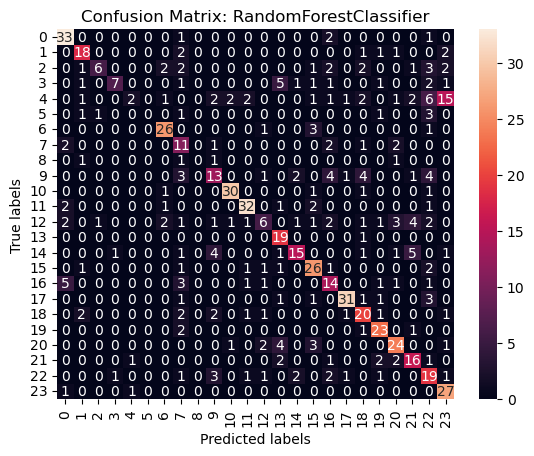

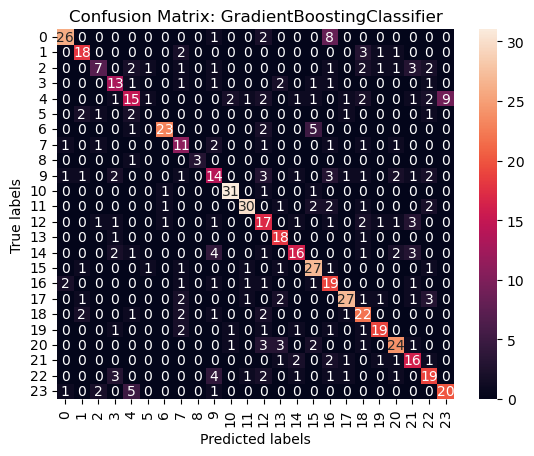

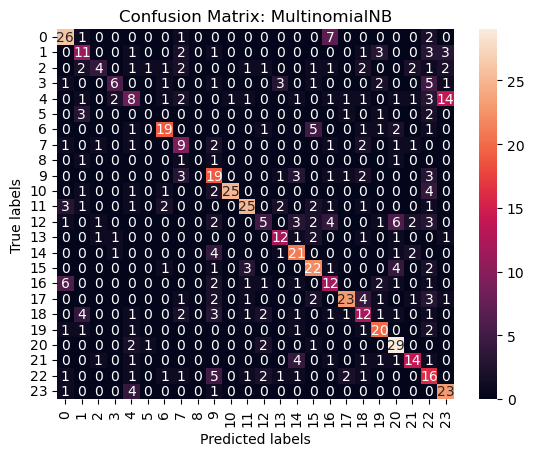

In [93]:
# visualize the resultant confussion matrix per model
x_test, y_test = df_splitted[1], df_splitted[3]
plot_confusion_matrix_models(best_models, x_test, y_test)

__Model Evaluation:__

Finally, let's __evaluate our models with new data__ (not used from train or testing).

We will use __x_eval and y_eval from our splitted dataset__.

In [95]:
# select our 2 final candidate models
final_models = [best_models[1], best_models[2]]
final_models

[RandomForestClassifier(n_estimators=1000), GradientBoostingClassifier()]

In [98]:
# function to display metrics for evaluation
def display_metrics(y_eval, y_pred_eval):
    # display accuracy and f1 scores
    print('- Acuracy Score Evaluation:', accuracy_score(y_eval, y_pred_eval).round(3))
    print('- F1 Score Evaluation:', f1_score(y_eval, y_pred_eval, average='micro').round(3), end='\n\n')
    
# function to confusion matrixes from a group of models using evaluation set
def plot_confusion_matrix_models_evaluation(models, x_eval, y_eval):
    # loop through the models
    for model in models:
        
        name = type(model).__name__ # extract the model name
        
        y_pred_eval = model.predict(x_eval) # predict values
        
        print("Model:", name)
        display_metrics(y_eval, y_pred_eval)
        
        plot_confusion_matrix(y_eval, y_pred_eval, title_suffix=': '+name) # plot confusion matrix

Model: RandomForestClassifier
- Acuracy Score Evaluation: 0.851
- F1 Score Evaluation: 0.851



Model: GradientBoostingClassifier
- Acuracy Score Evaluation: 0.871
- F1 Score Evaluation: 0.871



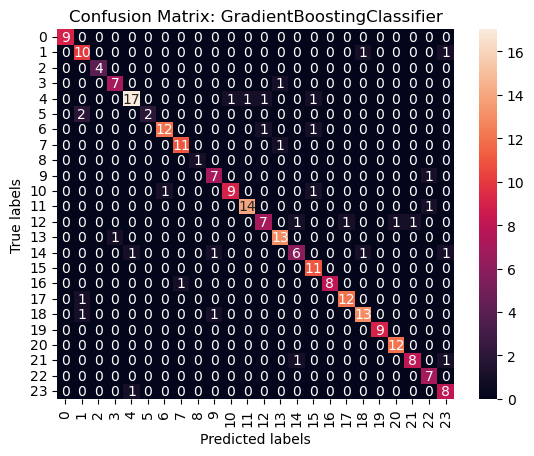

In [99]:
# evaluate our final models with new data (not used for train and test)
plot_confusion_matrix_models_evaluation(final_models, x_eval, y_eval)

__From evaluation results:__
- __Both models__ (Random Forest and Gradient Boosting) show remarkable __accuracies and F1-Scores of 85-87%__
- __Gradient Boosting Classifier__ shows a slightly __better performance (2% better than Random Forest)__

We choose the __Gradient Boosting Classifier__ as our final model to __predict industries from resumes with an accuracy of 87%.__

### Labeling new resumes from unknown industries

Now that we have a model we can test labeling new resumes from unknown industries.

This data source was retrieved from Kaggle (https://www.kaggle.com/datasets/palaksood97/resume-dataset).

This __new data is in Word (docx) format__. So we will need to extract the texts from these type of files.

In [108]:
# saving our best model
final_model = final_models[1]

In [100]:
import docx

# function to read text from Word document
def get_text_from_docx(file_path):
    
    # read the Word file
    file = docx.Document(file_path)
    
    # extract the text into a list by looping through the paragraphs
    text_list = [paragraph.text for paragraph in file.paragraphs]
    
    # join the entire text, separating lines by CR char
    return '\n'.join(text_list)

# function to read resumes from a folder full of resumes in Word format
def get_resumes_from_docx(folder_path):
    
    # instantiate our resume data loader class
    rdl = ResumeDataLoader()
    
    # get file names from a folder path
    files = rdl.get_list_of_files(folder_path)
    
    # extract the resumes texts using our function
    return [get_text_from_docx('./'+folder_path+'/'+file) for file in files]
        
        
resumes = get_resumes_from_docx('Data_source_1')

In [101]:
print("Number of Resumes:", len(resumes))
resumes[0][:250] # first 250 characters of the 1st resume

Number of Resumes: 228


'Name: Abiral Pandey\nEmail: abiral.pandey88@gmail.com\nPhone: 940-242-3303\nCurrent Location: Woonsocket, Rhode Island\nVisa Status: US Citizen\n\nSUMMARY:\nDynamic individual with 6 years of software development experience in\xa0design, development, deploymen'

__We have 228 unlabeled resumes. Let's clean these texts first.__

In [102]:
# function to clean a list of resumes using our previous clean_text function
def clean_list_resumes(resumes):
    for i, resume in enumerate(resumes):
        resumes[i] = clean_text(resume)

# clean our resume texts and visualize one example again
clean_list_resumes(resumes)
print("Number of Resumes:", len(resumes))
resumes[0][:250] # first 250 characters of the 1st resume

Number of Resumes: 228


'name abiral pandey email abiralpandey gmailcom phone current location woonsocket rhode island visa status us citizen summary dynamic individual years software development experience design development deployment maintenance production support web bas'

In [116]:
# function to build the dataset from resumes and extracted features (for evaluation)
def get_dataset_from_resumes_word(resumes, extracted_features):
    
    # loop through the clean text resumes and the targets (profession/industry)
    dataset = []
    for resume in resumes:
        
        # set the feature values from the resume text and previously extracted features
        features = search_features(resume, extracted_features)
        
        # append the features to the dataset
        dataset.append(features)
    
    # convert the dataset (list of dictionaries) into a pandas Dataframe
    return pd.DataFrame(dataset)

# get the evaluation dataframe
df_unlabeled = get_dataset_from_resumes_word(resumes, extracted_features)
df_unlabeled

network  nutrition     â·  create  infrastructure   cash  specialist  \
0       True      False  False    True           False  False       False   
1      False      False  False    True           False  False       False   
2       True      False  False   False            True  False       False   
3       True      False  False    True           False   True       False   
4      False      False  False    True           False  False       False   
..       ...        ...    ...     ...             ...    ...         ...   
223     True      False  False   False           False   True       False   
224     True      False  False   False            True  False       False   
225    False      False  False    True           False  False       False   
226    False      False  False    True            True   True       False   
227     True      False  False    True           False  False       False   

     installation  fitness  relationships  ...  contractors  administrative  \
0            True    False          False  ...        False           False   
1           False    False           True  ...        False           False   
2           False    False          False  ...         True           False   
3           False    False          False  ...        False           False   
4           False    False           True  ...        False           False   
..            ...      ...            ...  ...          ...             ...   
223         False    False          False  ...        False           False   
224         False    False          False  ...        False            True   
225         False    False          False  ...        False           False   
226         False    False           True  ...        False           False   
227         False    False          False  ...        False           False   

     classes  various  fixed  data  performance  services  accounting  media  
0       True     True  False  True         True      True       False  False  
1       True     True   True  True         True      True       False  False  
2      False     True  False  True         True     False       False  False  
3      False     True  False  True         True      True       False  False  
4      False     True  False  True         True      True       False  False  
..       ...      ...    ...   ...          ...       ...         ...    ...  
223     True     True  False  True         True      True       False  False  
224    False    False  False  True         True      True       False  False  
225     True     True  False  True         True      True       False  False  
226    False     True  False  True         True      True       False  False  
227     True     True  False  True         True      True       False  False  

[228 rows x 480 columns]

In [117]:
# function to apply label encoding on our unlabeled dataframe
def apply_label_encoding_on_df_unlabeled(df_original):
    
    # create a copy of the df for safety
    df = df_original.copy()
    
    # map feature boolean values
    df.replace(to_replace = False, value = 0, inplace=True)
    df.replace(to_replace = True, value = 1, inplace=True)
    
    return df

df_unlabeled = apply_label_encoding_on_df_unlabeled(df_unlabeled)
df_unlabeled

network  nutrition  â·  create  infrastructure  cash  specialist  \
0          1          0   0       1               0     0           0   
1          0          0   0       1               0     0           0   
2          1          0   0       0               1     0           0   
3          1          0   0       1               0     1           0   
4          0          0   0       1               0     0           0   
..       ...        ...  ..     ...             ...   ...         ...   
223        1          0   0       0               0     1           0   
224        1          0   0       0               1     0           0   
225        0          0   0       1               0     0           0   
226        0          0   0       1               1     1           0   
227        1          0   0       1               0     0           0   

     installation  fitness  relationships  ...  contractors  administrative  \
0               1        0              0  ...            0               0   
1               0        0              1  ...            0               0   
2               0        0              0  ...            1               0   
3               0        0              0  ...            0               0   
4               0        0              1  ...            0               0   
..            ...      ...            ...  ...          ...             ...   
223             0        0              0  ...            0               0   
224             0        0              0  ...            0               1   
225             0        0              0  ...            0               0   
226             0        0              1  ...            0               0   
227             0        0              0  ...            0               0   

     classes  various  fixed  data  performance  services  accounting  media  
0          1        1      0     1            1         1           0      0  
1          1        1      1     1            1         1           0      0  
2          0        1      0     1            1         0           0      0  
3          0        1      0     1            1         1           0      0  
4          0        1      0     1            1         1           0      0  
..       ...      ...    ...   ...          ...       ...         ...    ...  
223        1        1      0     1            1         1           0      0  
224        0        0      0     1            1         1           0      0  
225        1        1      0     1            1         1           0      0  
226        0        1      0     1            1         1           0      0  
227        1        1      0     1            1         1           0      0  

[228 rows x 480 columns]

In [120]:
# predicting the unknown resume labels
resume_labels = final_model.predict(df_unlabeled)
resume_labels[:30] # display first 30 predictions

array(['automobile', 'banking', 'construction', 'banking', 'bpo',
       'banking', 'banking', 'banking', 'designer', 'bpo', 'banking',
       'banking', 'healthcare', 'bpo', 'engineering', 'bpo', 'healthcare',
       'banking', 'healthcare', 'designer', 'banking',
       'business development', 'banking', 'consultant', 'banking',
       'banking', 'designer', 'engineering', 'bpo', 'consultant'],
      dtype=object)

In [121]:
# joining the predictions to the dataframe
df_unlabeled['industry'] = resume_labels
df_unlabeled

network  nutrition  â·  create  infrastructure  cash  specialist  \
0          1          0   0       1               0     0           0   
1          0          0   0       1               0     0           0   
2          1          0   0       0               1     0           0   
3          1          0   0       1               0     1           0   
4          0          0   0       1               0     0           0   
..       ...        ...  ..     ...             ...   ...         ...   
223        1          0   0       0               0     1           0   
224        1          0   0       0               1     0           0   
225        0          0   0       1               0     0           0   
226        0          0   0       1               1     1           0   
227        1          0   0       1               0     0           0   

     installation  fitness  relationships  ...  administrative  classes  \
0               1        0              0  ...               0        1   
1               0        0              1  ...               0        1   
2               0        0              0  ...               0        0   
3               0        0              0  ...               0        0   
4               0        0              1  ...               0        0   
..            ...      ...            ...  ...             ...      ...   
223             0        0              0  ...               0        1   
224             0        0              0  ...               1        0   
225             0        0              0  ...               0        1   
226             0        0              1  ...               0        0   
227             0        0              0  ...               0        1   

     various  fixed  data  performance  services  accounting  media  \
0          1      0     1            1         1           0      0   
1          1      1     1            1         1           0      0   
2          1      0     1            1         0           0      0   
3          1      0     1            1         1           0      0   
4          1      0     1            1         1           0      0   
..       ...    ...   ...          ...       ...         ...    ...   
223        1      0     1            1         1           0      0   
224        0      0     1            1         1           0      0   
225        1      0     1            1         1           0      0   
226        1      0     1            1         1           0      0   
227        1      0     1            1         1           0      0   

                   industry  
0                automobile  
1                   banking  
2              construction  
3                   banking  
4                       bpo  
..                      ...  
223                     bpo  
224  information technology  
225                 banking  
226                designer  
227                 banking  

[228 rows x 481 columns]

In [122]:
# EDA on the resultant labeled dataframe from unknown resumes
eda = EDA(df_unlabeled)
eda.barPlot('industry', orient='h')

-------------------------------------------------- 

SHAPE OF DATAFRAME:
Columns = 228
Rows = 481
-------------------------------------------------- 

SIZE OF DATAFRAME: 109668
-------------------------------------------------- 

Checking the missing values:

Missing values:
network           0
nutrition         0
â·                0
create            0
infrastructure    0
                 ..
performance       0
services          0
accounting        0
media             0
industry          0
Length: 481, dtype: int64
-------------------------------------------------- 

Checking the Duplicate values:
Duplicate values = 7
-------------------------------------------------- 

The information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Columns: 481 entries, network to industry
dtypes: int64(480), object(1)
memory usage: 856.9+ KB
None 


__Final insights:__

- Our dataset of unlabeled resumes succesfully labeled the resumes throughout 12 different industries (baking being the predominant).
- Our best model was __Gradient Boosting Classifier__ with a remarkable __evaluation (new data) accuracy of 87%.__
- We also __built a pipeline to convert Word files resumes into a Pandas DataFrame__ that can be used to predict their industries using our model.

To increase the model's accuracy we may need:
- more resumes (increase the amount of data)
- test more parameters during hyper-parameter tuning
- increase the different types of classification models tested (we did 4)

Overall, our __trained model can help us predict the industry from a given resume with an accuracy of 87%__, but this is only __1 of the various features that we have developed throughout the notebook__ for our final product __JobsPyMatcher__, a tool that __centralizes features to enhance targeted resumes__.